In [0]:
import pandas as pd
import sklearn.model_selection
import sklearn.ensemble

#gf
import mlflow
import mlflow.keras
import mlflow.tensorflow
from hyperopt import fmin, tpe, hp, SparkTrials, Trials, STATUS_OK
from hyperopt.pyll import scope

from tensorflow.keras.layers import Dense, LSTM
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Normalization
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

#import streamlit as st
import joblib

import tensorflow as tf
#Librerias para redes neuronales(secuencial)
from tensorflow.keras.models import Sequential
#Capa completamente conectada
from tensorflow.keras.layers import Dense, Normalization
#Optimizador
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

# Configurar pandas para mostrar todas las filas y columnas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#### 1. Leer datos para crear los Modelos IA

In [0]:
df_delta = spark.read.format("delta").load("/mnt/datalakemlopsd4m/presentation/proyectopases_presentation/datos_presentation_tabladelta_bi")
datos = df_delta.toPandas()
datos.head()

,id_ciclo_acarreo,id_cargadescarga_ciclo,id_palas,id_equipo_camion,id_ciclo_carguio,id_equipo_carguio,id_trabajador_pala,id_guardia_realiza_carga_al_camion,id_locacion_hace_carga,id_poligono_se_obtiene_material,tiempo_inicio_carga_carguio,tiempo_esperando_carguio,tiempo_ready_cargando_pala,tiempo_ready_esperando_pala,previous_esperando_pala,al_termino_cargar_en_espera_cuadrado_cuadrandose,cambio_estado_operatividad_carguio,cantidad_equipos_espera_al_termino_carga_pala,id_estados_camion,id_equipo_table_estados_camion,id_detal_estado_camion,tiempo_inicio_cambio_estado_camion,tiempo_estimado_duracion_estado_camion,en_campo_o_taller_mantenimiento_camion,id_tipo_estad_camion,estado_detalle_camion,estado_secundario_camion,estado_primario_camion,id_estados_pala,id_equipo_table_estados_pala,id_detal_estado_pala,tiempo_inicio_cambio_estado_pala,tiempo_estimado_duracion_estado_pala,en_campo_o_taller_mantenimiento_pala,id_tipo_estad_pala,estado_detalle_pala,estado_secundario_pala,estado_primario_pala,id_zona_hace_descarga,id_factor,id_poligono,tiempo_llegada_camion,tiempo_esperando_camion_en_locacion,tiempo_cuadra_camion,tiempo_cuadrado_camion,tiempo_cargar_al_camion,tiempo_acarreo_camion,tiempo_cola_camion_en_zonadescarga,tiempo_retroceso_para_descargar,tiempo_listo_para_descargar,tiempo_descarga_camion,tiempo_viajando_vacio_locacion,tiempo_ready_llegada_esperando,tiempo_ready_esperando_cuadra,tiempo_ready_cuadra_cuadrado,tiempo_ready_cuadrado_cargado,tiempo_ready_carga_acarreo,tiempo_ready_acarreo_cola,tiempo_ready_cola_retro,tiempo_ready_retro_listo,tiempo_ready_listo_descarga,tiempo_ready_descarga_viajandovacio,id_trabajador_camion,id_palanext,tonelaje_nominal,tonelaje_segun_computadora,cambios_estado_en_ciclo,id_guardia_hizocarga,id_guardia_hizodescarga,id_zona_aplicafactor,id_zona_pertenece_poligono,factor,toneladas_secas,productividad_operativa_acarreo_tn_h,productividad_operativa_carguio_tn_h,efhcargado_mts,efhvacio_mts,distancia_recorrida_camioncargado_km_gps_mts,distancia_recorrida_camionvacio_km_gps_mts,coordenada_x_descarga_km,coordenada_y_descarga_km,coordenada_z_descarga_km,tipo_descarga_efectuado,tonelaje_camion_viajevacio_cicloanterior_vims,tonelaje_camion_viajevacio_cicloactual_vims,promedio_velocidad_camioncargado_km/hr_compu,promedio_velocidad_camionvacio_km/hr_compu,promedio_velocidad_camioncargado_km/hr_gps,promedio_velocidad_camionvacio_km/hr_gps,tonelaje_camion_antes_cargaestabilizada,porcentaje_combustible_camioncargando,porcentaje_combustible_camiondescargando,volumen_nominal,aplica_factor_volumen_o_tonelaje,nivel_descarga_metros,efh_factor_loaded,efh_factor_empty,nombre_equipo_acarreo,id_flota_secundaria,nombre_flota_secundaria,id_flota_principal,nombre_flota_principal,capacidad_en_volumen_equipo_acarreo_m3,capacidad_en_peso_equipo_acarreo,capacidadtanque_equipoacarreo_galones,peso_bruto_equipo_acarreo,si_no_equipo_altaprecision,ancho_equipo_metros,largo_equipo_metros,numeroejes_equipo,nombre_equipo_carguio,capacidad_en_volumen_equipo_carguio_m3,capacidad_en_peso_equipo_carguio,capacidadtanque_equipocarguio_galones,radiohexagonocuchara_equipocarguio,id_turnos_turnocarga,nombre_turnocarga,horaini_turnocarga,horafin_turnocarga,id_turnos_turnodescarga,nombre_turnodescarga,horaini_turnodescarga,horafin_turnodescarga,id_zona_encuentra_descarga,id_nodo_carga,id_nodo_descarga,nivel_elevacion_descarga_metros,nombre_zona_descarga,nombre_locacion_carga,nivel_elevacion_locacion_carga_metros,radio_locacion_metros,ids_poligonos_en_locacion_carga,id_material_dominante_en_poligono,nombre_poligono,elevacion_poligono_metros,lista_leyes,densidad_inicial_poligono_creado_tn/m3,tonelaje_inicial_poligono_creado,id_pases,id_palas_pases,coord_x_pases,coord_y_pases,coord_z_pases,angulo_giro_pases,tonelaje_pases,duracion_excavacion_pases,angulo_giro_promedio_pases,has_block_pases,porcentaje_eficiencia_toneladas_movidas_acarreo,altura_elevacion,factor_perfil_rutavacio,factor_perfil_rutacargado,numero_pases_carguio,Galones_disponibles_cami

In [0]:
datos.dtypes

id_ciclo_acarreo                                                  int64
id_cargadescarga_ciclo                                            int64
id_palas                                                          int64
id_equipo_camion                                                  int64
id_ciclo_carguio                                                float64
id_equipo_carguio                                               float64
id_trabajador_pala                                              float64
id_guardia_realiza_carga_al_camion                              float64
id_locacion_hace_carga                                          float64
id_poligono_se_obtiene_material                                 float64
tiempo_inicio_carga_carguio                              datetime64[us]
tiempo_esperando_carguio                                 datetime64[us]
tiempo_ready_cargando_pala                                      float64
tiempo_ready_esperando_pala                                     

Veamos el periodo de datos que estaremos utilizando

In [0]:
datos['tiempo_inicio_carga_carguio'].min(), datos['tiempo_inicio_carga_carguio'].max(), 

(Timestamp('2022-01-01 12:04:37.426000'),
 Timestamp('2023-09-06 20:38:49.879000'))

Veamos la dimension de los datos a utilizar

In [0]:
datos.shape

(330118, 163)

#### 2. Hacemos un Tratamiento de variable categorica con One Hot Encoding

##### 2.1 Metodo 1 - Usando la libreria de One Hot Encoder de Sckilearn

In [0]:
from sklearn.preprocessing import OneHotEncoder
import pickle
# Aplicar el One Hot Encoding
encoder = OneHotEncoder(sparse_output=False)   # Saprce para manejar el numero de ceros, en la generacion del one hot encoding
one_hot = encoder.fit_transform(datos[['nombre_equipo_carguio']])

# Guardar el codificador One Hot Encoding entrenado
with open('one_hot_encoder_pases.pkl', 'wb') as f:
    pickle.dump(encoder, f)

# Convertir a DataFrame
one_hot_df = pd.DataFrame(one_hot, columns=encoder.get_feature_names_out(['nombre_equipo_carguio']))  #equipo_carguio , nombre acompanate en la columnas de los dummies

# Unir el DataFrame original con el codificado
datos = pd.concat([datos, one_hot_df], axis=1)

# Mostrar el resultado
datos.head()

In [0]:
# Supongamos que se agrega una nueva fila a la base de datos
nueva_fila = pd.DataFrame({'nombre_equipo_carguio': ['CF03']})

# # Cargar el codificador guardado
with open('one_hot_encoder_pases.pkl', 'rb') as f:
     encoder = pickle.load(f)

# # Transformar la nueva fila
one_hot_nueva_fila = encoder.transform(nueva_fila)

# # Convertir a DataFrame
one_hot_nueva_fila_df = pd.DataFrame(one_hot_nueva_fila, columns=encoder.get_feature_names_out(['nombre_equipo_carguio']))

one_hot_nueva_fila_df  # De aqui filtras las columnas y le vas pasando al Modelo de IA

,nombre_equipo_carguio_CF01,nombre_equipo_carguio_CF02,nombre_equipo_carguio_CF03,nombre_equipo_carguio_FR01,nombre_equipo_carguio_PH01,nombre_equipo_carguio_PH02,nombre_equipo_carguio_PH03
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


##### 2.2 Metodo 2 -  Usar un bucle para realizar el codigo de One Hot Encoding

VARIABLE nombre_equipo_carguio

In [0]:
import pandas as pd

# Obtener las categorías únicas
categorias = datos['nombre_equipo_carguio'].unique()

# Crear un DataFrame vacío con columnas para cada categoría, Diccionario one_hot_dict : categoria: clave es una categoría única de #nombre_equipo_carguio, y el [0]*len(datos) : valor asociado a cada clave es una lista de ceros de la misma longitud que el DataFrame 
one_hot_dict = {categoria: [0]*len(datos) for categoria in categorias}

# Llenar el diccionario con 1s en las posiciones correspondientes
# idx es el índice de la fila, val es el valor de nombre_equipo_carguio en esa fila
# Si idx=0 y val='CF02', entonces one_hot_dict['CF02'][0] = 1
for idx, val in datos['nombre_equipo_carguio'].items():
    one_hot_dict[val][idx] = 1

# Convertir el diccionario a un DataFrame
one_hot_df = pd.DataFrame(one_hot_dict)

#Unir el DataFrame original con el codificado
datos = pd.concat([datos, one_hot_df], axis=1)

# # Mostrar el resultado
datos[['nombre_equipo_carguio','CF02','CF01', 'CF03', 'PH03', 'PH02', 'PH01', 'FR01']].head()

,nombre_equipo_carguio,CF02,CF01,CF03,PH03,PH02,PH01,FR01
0,CF02,1,0,0,0,0,0,0
1,CF01,0,1,0,0,0,0,0
2,CF03,0,0,1,0,0,0,0
3,CF01,0,1,0,0,0,0,0
4,PH03,0,0,0,1,0,0,0


In [0]:
categorias

array(['CF02', 'CF01', 'CF03', 'PH03', 'PH02', 'PH01', 'FR01'],
      dtype=object)

VARIABLE Procedencia

In [0]:
# Obtener las categorías únicas
categorias_pro = datos['Procedencia'].unique()

# Crear un DataFrame vacío con columnas para cada categoría, Diccionario one_hot_dict : categoria: clave es una categoría única de #nombre_equipo_carguio, y el [0]*len(datos) : valor asociado a cada clave es una lista de ceros de la misma longitud que el DataFrame 
one_hot_dict_pro = {categoria: [0]*len(datos) for categoria in categorias_pro}

# Llenar el diccionario con 1s en las posiciones correspondientes
# idx es el índice de la fila, val es el valor de nombre_equipo_carguio en esa fila
# Si idx=0 y val='CF02', entonces one_hot_dict['CF02'][0] = 1
for idx, val in datos['Procedencia'].items():
    one_hot_dict_pro[val][idx] = 1

# Convertir el diccionario a un DataFrame
one_hot_dict_pro_df = pd.DataFrame(one_hot_dict_pro)

#Unir el DataFrame original con el codificado
datos = pd.concat([datos, one_hot_dict_pro_df], axis=1)

# # Mostrar el resultado
datos[['Procedencia','TAJ', 'SUL', 'OXI', 'NoDefinido']].head()

,Procedencia,TAJ,SUL,OXI,NoDefinido
0,TAJ,1,0,0,0
1,TAJ,1,0,0,0
2,SUL,0,1,0,0
3,TAJ,1,0,0,0
4,TAJ,1,0,0,0


#### 3. Hacemos un tratamiento de variable Boleana para convertir a Numerica por el Metodo del Mapping

Variable al_termino_cargar_en_espera_cuadrado_cuadrandose

In [0]:
# # Crear un diccionario para mapear valores booleanos a numéricos
bool_to_num = {True: 1, False: 0}

# # Aplicar el diccionario a la columna booleana para convertirla a numérica
datos['al_termino_cargar_en_espera_cuadrado_cuadrandose'] = datos['al_termino_cargar_en_espera_cuadrado_cuadrandose'].map(bool_to_num)

# Mostrar el resultado
datos['al_termino_cargar_en_espera_cuadrado_cuadrandose'].head()

0    0
1    0
2    0
3    0
4    1
Name: al_termino_cargar_en_espera_cuadrado_cuadrandose, dtype: int64

### 4. Seleccion de Variables

3.1 Seleccion variables con  StatModels, para regresion lineal (variables significativas estadisticamente basado en la Hipotesis Nula)

In [0]:
#Veamos el tipo de datos que estaremos utilizando
datos[['tonelaje_inicial_poligono_creado','radiohexagonocuchara_equipocarguio',
'capacidad_en_volumen_equipo_carguio_m3','capacidad_en_volumen_equipo_acarreo_m3',
'capacidad_en_peso_equipo_carguio',
'capacidad_en_peso_equipo_acarreo',
'tiempo_estimado_duracion_estado_pala',
'radio_locacion_metros',
'tiempo_ready_llegada_esperando',
'tonelaje_camion_antes_cargaestabilizada',
'tonelaje_segun_computadora',
'densidad_inicial_poligono_creado_tn/m3','tiempo_carga','al_termino_cargar_en_espera_cuadrado_cuadrandose',
'cantidad_equipos_espera_al_termino_carga_pala','horaini_turnocarga','elevacion_poligono_metros',
'CF02','CF01', 'CF03', 'PH03', 'PH02', 'PH01', 'FR01',
'TAJ', 'SUL', 'OXI', 'NoDefinido']].dtypes

tonelaje_inicial_poligono_creado                    float64
radiohexagonocuchara_equipocarguio                    int64
capacidad_en_volumen_equipo_carguio_m3              float64
capacidad_en_volumen_equipo_acarreo_m3              float64
capacidad_en_peso_equipo_carguio                    float64
capacidad_en_peso_equipo_acarreo                    float64
tiempo_estimado_duracion_estado_pala                float64
radio_locacion_metros                               float64
tiempo_ready_llegada_esperando                      float64
tonelaje_camion_antes_cargaestabilizada             float64
tonelaje_segun_computadora                          float64
densidad_inicial_poligono_creado_tn/m3              float64
tiempo_carga                                        float64
al_termino_cargar_en_espera_cuadrado_cuadrandose      int64
cantidad_equipos_espera_al_termino_carga_pala       float64
horaini_turnocarga                                    int64
elevacion_poligono_metros               

In [0]:
datos['numero_pases_carguio'].unique()

array([ 7,  9,  6,  5,  8,  4, 10, 11, 12])

In [0]:
import pandas as pd
import statsmodels.api as sm

# Supongamos que datos es tu DataFrame y has seleccionado tus características (X) y variable objetivo (y)
X = datos[['tonelaje_inicial_poligono_creado','radiohexagonocuchara_equipocarguio',
'capacidad_en_volumen_equipo_carguio_m3','capacidad_en_volumen_equipo_acarreo_m3',
'capacidad_en_peso_equipo_carguio',
'capacidad_en_peso_equipo_acarreo',
'tiempo_estimado_duracion_estado_pala',
'radio_locacion_metros',
'tiempo_ready_llegada_esperando',
'tonelaje_camion_antes_cargaestabilizada',
'tonelaje_segun_computadora',
'densidad_inicial_poligono_creado_tn/m3','tiempo_carga','al_termino_cargar_en_espera_cuadrado_cuadrandose',
'cantidad_equipos_espera_al_termino_carga_pala','horaini_turnocarga','elevacion_poligono_metros',
'CF02','CF01', 'CF03', 'PH03', 'PH02', 'PH01', 'FR01',
'TAJ', 'SUL', 'OXI', 'NoDefinido']]  # Reemplaza 'feature1', 'feature2', 'feature3' con tus nombres de características
y = datos['numero_pases_carguio'] # Reemplaza 'variable_objetivo' con el nombre de tu variable objetivo

# Añadir constante a las características (intercepto)
X = sm.add_constant(X)

# Crear el modelo de regresión lineal con statsmodels
modelo = sm.OLS(y, X).fit()

# Imprimir un resumen estadistico del modelo
print(modelo.summary())

                             OLS Regression Results                             
Dep. Variable:     numero_pases_carguio   R-squared:                       0.206
Model:                              OLS   Adj. R-squared:                  0.206
Method:                   Least Squares   F-statistic:                     4272.
Date:                  Fri, 12 Jul 2024   Prob (F-statistic):               0.00
Time:                          17:41:46   Log-Likelihood:            -5.2370e+05
No. Observations:                330118   AIC:                         1.047e+06
Df Residuals:                    330097   BIC:                         1.048e+06
Df Model:                            20                                         
Covariance Type:              nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

Variables descartadas

In [0]:
# capacidad_en_volumen_equipo_carguio_m3             
# capacidad_en_volumen_equipo_acarreo_m3            
# capacidad_en_peso_equipo_carguio                    
# capacidad_en_peso_equipo_acarreo   
# horaini_turnocarga      
# FR01            

3.2 Ver Correlaciones entre mis variables

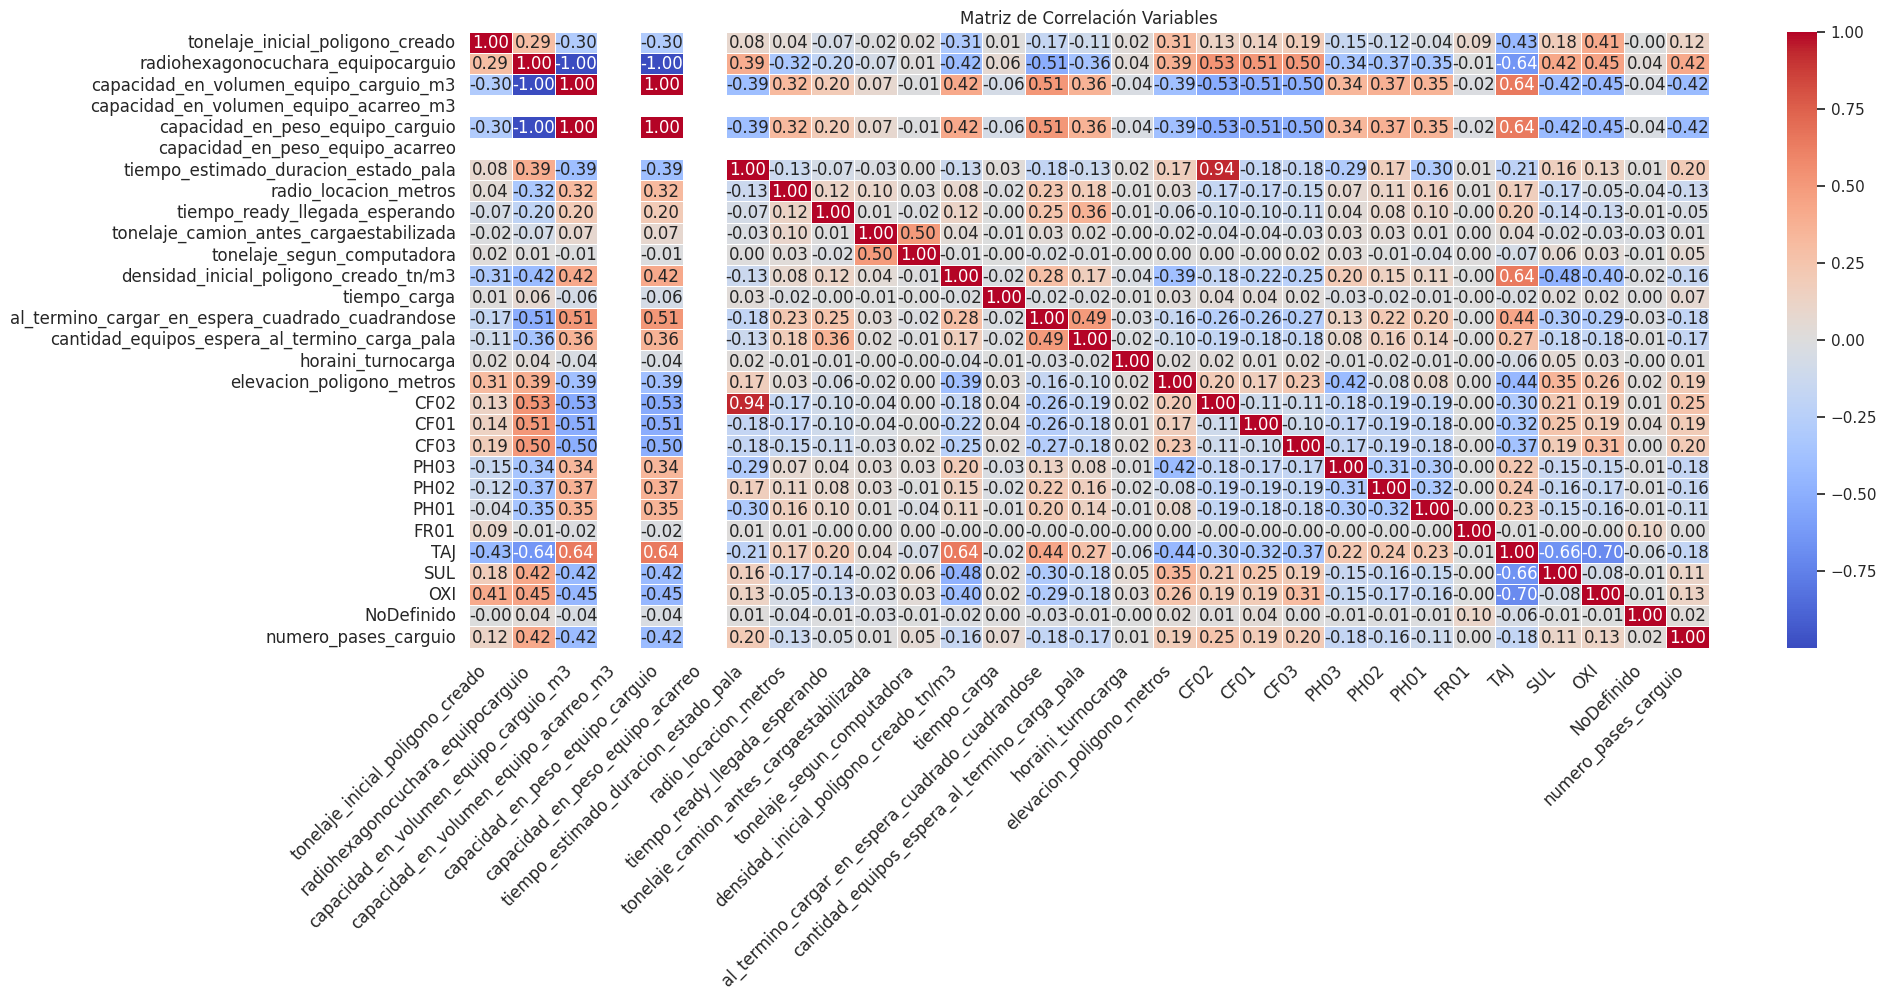

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Supongamos que tienes un DataFrame llamado 'datos'

# Lista de variables que deseas analizar
variables_a_analizar = ['tonelaje_inicial_poligono_creado','radiohexagonocuchara_equipocarguio',
'capacidad_en_volumen_equipo_carguio_m3','capacidad_en_volumen_equipo_acarreo_m3',
'capacidad_en_peso_equipo_carguio',
'capacidad_en_peso_equipo_acarreo',
'tiempo_estimado_duracion_estado_pala',
'radio_locacion_metros',
'tiempo_ready_llegada_esperando',
'tonelaje_camion_antes_cargaestabilizada',
'tonelaje_segun_computadora',
'densidad_inicial_poligono_creado_tn/m3','tiempo_carga','al_termino_cargar_en_espera_cuadrado_cuadrandose',
'cantidad_equipos_espera_al_termino_carga_pala','horaini_turnocarga','elevacion_poligono_metros',
'CF02','CF01', 'CF03', 'PH03', 'PH02', 'PH01', 'FR01',
'TAJ', 'SUL', 'OXI', 'NoDefinido','numero_pases_carguio']

# Filtrar el DataFrame para incluir solo las variables de interés
datos_subset = datos[variables_a_analizar]

# Crear una matriz de correlación para el subconjunto de variables
matriz_correlacion = datos_subset.corr()

# Configurar el estilo de Seaborn
sns.set(style="whitegrid")

# Aumentar el tamaño del gráfico para mostrar más detalles
plt.figure(figsize=(20, 8))

# Crear un mapa de calor (heatmap) de la matriz de correlación con desplazamiento habilitado
ax = sns.heatmap(matriz_correlacion, annot=True, fmt=".2f", cmap="coolwarm", linewidths=.5)

# Agregar etiquetas a los ejes X e Y
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, horizontalalignment='right', fontsize=8)

# Ajustar el tamaño de las fuentes de los nombres de las variables (eje x)
ax.tick_params(axis='x', labelsize=12)

# Ajustar el tamaño de las fuentes de los nombres de las variables (eje y)
ax.tick_params(axis='y', labelsize=12)

plt.title("Matriz de Correlación Variables")
plt.show()

In [0]:
# Variables seleccionadas con 20% de correlacion o superior
# 'radiohexagonocuchara_equipocarguio',
# 'capacidad_en_volumen_equipo_carguio_m3',
# 'capacidad_en_peso_equipo_carguio',
# 'tiempo_estimado_duracion_estado_pala',
# 'CF02','CF01', 'CF03', 'PH03', 'PH02', 'PH01', 'FR01',
# 'TAJ', 'SUL', 'OXI', 'NoDefinido'

3.3 Ver la varianza de mis variables

In [0]:
datos_varianza=datos[['tonelaje_inicial_poligono_creado','radiohexagonocuchara_equipocarguio',
'capacidad_en_volumen_equipo_carguio_m3','capacidad_en_volumen_equipo_acarreo_m3',
'capacidad_en_peso_equipo_carguio',
'capacidad_en_peso_equipo_acarreo',
'tiempo_estimado_duracion_estado_pala',
'radio_locacion_metros',
'tiempo_ready_llegada_esperando',
'tonelaje_camion_antes_cargaestabilizada', 'tonelaje_segun_computadora',
'densidad_inicial_poligono_creado_tn/m3','tiempo_carga','al_termino_cargar_en_espera_cuadrado_cuadrandose',
'cantidad_equipos_espera_al_termino_carga_pala','horaini_turnocarga','elevacion_poligono_metros',
'CF02','CF01', 'CF03', 'PH03', 'PH02', 'PH01', 'FR01',
'TAJ', 'SUL', 'OXI', 'NoDefinido']]

In [0]:
desviacion_estandar_sorted

tonelaje_inicial_poligono_creado                    556792.961750
tiempo_carga                                           431.051328
tiempo_estimado_duracion_estado_pala                   360.086746
tonelaje_camion_antes_cargaestabilizada                174.844553
radiohexagonocuchara_equipocarguio                     172.414881
tiempo_ready_llegada_esperando                         151.484485
elevacion_poligono_metros                               81.345765
radio_locacion_metros                                   11.099849
tonelaje_segun_computadora                               9.795882
capacidad_en_peso_equipo_carguio                         2.650838
capacidad_en_volumen_equipo_carguio_m3                   1.815182
cantidad_equipos_espera_al_termino_carga_pala            0.757897
horaini_turnocarga                                       0.581122
densidad_inicial_poligono_creado_tn/m3                   0.505074
al_termino_cargar_en_espera_cuadrado_cuadrandose         0.492696
PH02      

In [0]:
#Varibales a descartar porque no aportan informacion al Modelo
#capacidad_en_peso_equipo_acarreo                         0.000000
# capacidad_en_volumen_equipo_acarreo_m3                   0.000000

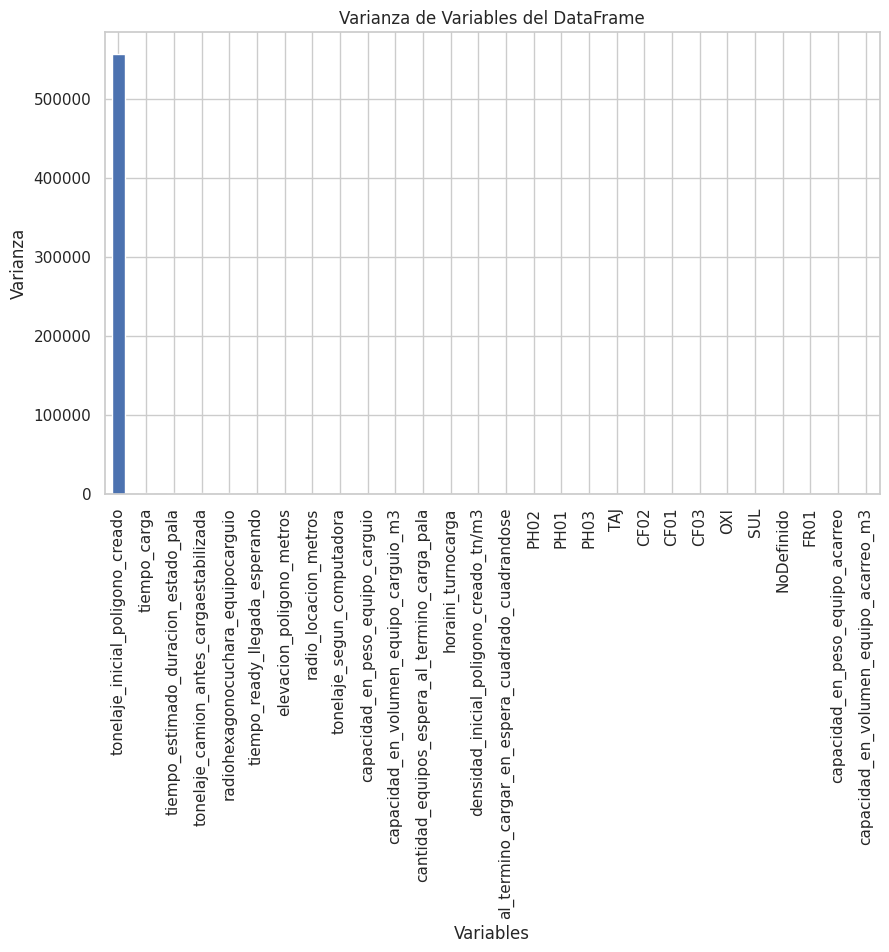

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Calcular la varianza de cada columna
desviacion_estandar = np.sqrt(datos_varianza.var())  #desviacion estandar 

# Redondear la varianza a 2 decimales
#variance_rounded = variance.round(2)

# Ordenar las varianzas de mayor a menor
desviacion_estandar_sorted = desviacion_estandar.sort_values(ascending=False)

# Graficar los resultados
plt.figure(figsize=(10, 6))
desviacion_estandar_sorted.plot(kind='bar')
plt.title('Varianza de Variables del DataFrame')
plt.xlabel('Variables')
plt.ylabel('Varianza')
# plt.xticks(rotation=45)
plt.show()

#### Variables Seleccionadas antes de entrenar los modelos de ML

In [0]:
datos_subset=datos[['tonelaje_inicial_poligono_creado','radiohexagonocuchara_equipocarguio',
'capacidad_en_volumen_equipo_carguio_m3',
#'capacidad_en_volumen_equipo_acarreo_m3', #varianza 0
'capacidad_en_peso_equipo_carguio',
#'capacidad_en_peso_equipo_acarreo',  # varianza 0
'tiempo_estimado_duracion_estado_pala',
'radio_locacion_metros',
'tiempo_ready_llegada_esperando',
'tonelaje_camion_antes_cargaestabilizada',
'tonelaje_segun_computadora',
'densidad_inicial_poligono_creado_tn/m3','tiempo_carga','al_termino_cargar_en_espera_cuadrado_cuadrandose',
'cantidad_equipos_espera_al_termino_carga_pala','horaini_turnocarga','elevacion_poligono_metros',
'CF02','CF01', 'CF03', 'PH03', 'PH02', 'PH01', 'FR01',
'TAJ', 'SUL', 'OXI', 'NoDefinido']]
datos_subset.head()

,tonelaje_inicial_poligono_creado,radiohexagonocuchara_equipocarguio,capacidad_en_volumen_equipo_carguio_m3,capacidad_en_peso_equipo_carguio,tiempo_estimado_duracion_estado_pala,radio_locacion_metros,tiempo_ready_llegada_esperando,tonelaje_camion_antes_cargaestabilizada,tonelaje_segun_computadora,densidad_inicial_poligono_creado_tn/m3,tiempo_carga,al_termino_cargar_en_espera_cuadrado_cuadrandose,cantidad_equipos_espera_al_termino_carga_pala,horaini_turnocarga,elevacion_poligono_metros,CF02,CF01,CF03,PH03,PH02,PH01,FR01,TAJ,SUL,OXI,NoDefinido
0,292302.480,680,23.0,39.158333,1200.0,45.0,0.000,2209.0,237.1,2.738,208.036,0,0.0,7,728.0,1,0,0,0,0,0,0,1,0,0,0
1,178217.372,680,23.0,39.158333,0.0,40.0,0.000,2302.0,229.9,2.675,190.024,0,0.0,7,728.0,0,1,0,0,0,0,0,1,0,0,0
2,77500.000,680,23.0,39.158333,0.0,35.0,0.000,2383.0,248.2,2.200,248.024,0,0.0,7,780.0,0,0,1,0,0,0,0,0,1,0,0
3,178217.372,680,23.0,39.158333,0.0,40.0,0.000,2107.0,231.2,2.675,210.018,0,0.0,7,728.0,0,1,0,0,0,0,0,1,0,0,0
4,140413.834,300,27.0,45.000000,0.0,50.0,170.807,2268.0,226.8,2.790,182.019,1,2.0,7,536.0,0,0,0,1,0,0,0,1,0,0,0


###4. Funcion para Escalar datos, y guardar los valores para escalar en produccion

4.1 Hallamos los Minimos y Maximos de cada Variable a escalar

In [0]:
# Selecciona las variables específicas
variables_especificas = ['tonelaje_inicial_poligono_creado','radiohexagonocuchara_equipocarguio',
                         'capacidad_en_volumen_equipo_carguio_m3',
                         'capacidad_en_peso_equipo_carguio',
                         'tiempo_estimado_duracion_estado_pala','radio_locacion_metros',
                         'tiempo_ready_llegada_esperando','tonelaje_camion_antes_cargaestabilizada',
                         'tonelaje_segun_computadora',
                         'densidad_inicial_poligono_creado_tn/m3','tiempo_carga',
                         'cantidad_equipos_espera_al_termino_carga_pala','horaini_turnocarga','elevacion_poligono_metros']

# Crear un DataFrame con las variables específicas
datos_subset_escalar = datos_subset[variables_especificas]

In [0]:
X_min = datos_subset_escalar.min()
X_max = datos_subset_escalar.max()
X_min, X_max

(tonelaje_inicial_poligono_creado                      0.000
 radiohexagonocuchara_equipocarguio                    0.000
 capacidad_en_volumen_equipo_carguio_m3               12.000
 capacidad_en_peso_equipo_carguio                     25.000
 tiempo_estimado_duracion_estado_pala                  0.000
 radio_locacion_metros                                 0.000
 tiempo_ready_llegada_esperando                        0.000
 tonelaje_camion_antes_cargaestabilizada               0.000
 tonelaje_segun_computadora                          152.800
 densidad_inicial_poligono_creado_tn/m3                0.000
 tiempo_carga                                    -242063.328
 cantidad_equipos_espera_al_termino_carga_pala        -1.000
 horaini_turnocarga                                    7.000
 elevacion_poligono_metros                           464.000
 dtype: float64,
 tonelaje_inicial_poligono_creado                 2.000000e+07
 radiohexagonocuchara_equipocarguio               6.800000e+02
 ca

4.2 Generamos la funcion para generar el escalamiento que dejara valores entre 0 y 1 

In [0]:
X_max.values

array([2.00000000e+07, 6.80000000e+02, 2.70000000e+01, 4.50000000e+01,
       1.80000000e+03, 4.00000000e+02, 3.51744191e+03, 3.09900000e+03,
       3.20600000e+02, 4.24100000e+00, 3.14238200e+03, 8.00000000e+00,
       1.90000000e+01, 8.37000000e+02])

In [0]:
X_minimo = np.array([  0.00000000e+00,  0.00000000e+00,  1.20000000e+01,  2.50000000e+01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.52800000e+02,  0.00000000e+00, -2.42063328e+05, -1.00000000e+00,
        7.00000000e+00,  4.64000000e+02])
X_maximo = np.array([2.00000000e+07, 6.80000000e+02, 2.70000000e+01, 4.50000000e+01,
       1.80000000e+03, 4.00000000e+02, 3.51744191e+03, 3.09900000e+03,
       3.20600000e+02, 4.24100000e+00, 3.14238200e+03, 8.00000000e+00,
       1.90000000e+01, 8.37000000e+02])
def min_max_scale(data, X_min, X_max):
    '''
    Parámetros:
    - data: Un array NumPy con los datos crudos.
    - X_min: Un array NumPy con los valores mínimos para cada característica.
    - X_max: Un array NumPy con los valores máximos para cada característica.
    '''
    data_scaled = (data - X_min) / (X_max - X_min)
    return data_scaled
datos_subset_escalados = min_max_scale(datos_subset_escalar,X_minimo, X_maximo)
datos_subset_escalados.head()

,tonelaje_inicial_poligono_creado,radiohexagonocuchara_equipocarguio,capacidad_en_volumen_equipo_carguio_m3,capacidad_en_peso_equipo_carguio,tiempo_estimado_duracion_estado_pala,radio_locacion_metros,tiempo_ready_llegada_esperando,tonelaje_camion_antes_cargaestabilizada,tonelaje_segun_computadora,densidad_inicial_poligono_creado_tn/m3,tiempo_carga,cantidad_equipos_espera_al_termino_carga_pala,horaini_turnocarga,elevacion_poligono_metros
0,0.014615,1.000000,0.733333,0.707917,0.666667,0.1125,0.00000,0.712811,0.502384,0.645602,0.988033,0.111111,0.0,0.707775
1,0.008911,1.000000,0.733333,0.707917,0.000000,0.1000,0.00000,0.742820,0.459476,0.630747,0.987960,0.111111,0.0,0.707775
2,0.003875,1.000000,0.733333,0.707917,0.000000,0.0875,0.00000,0.768958,0.568534,0.518746,0.988196,0.111111,0.0,0.847185
3,0.008911,1.000000,0.733333,0.707917,0.000000,0.1000,0.00000,0.679897,0.467223,0.630747,0.988041,0.111111,0.0,0.707775
4,0.007021,0.441176,1.000000,1.000000,0.000000,0.1250,0.04856,0.731849,0.441001,0.657864,0.987927,0.333333,0.0,0.193029


In [0]:
# 3 Verificamos que no haya valores NULL luego de hacer el Escalamiento de Datos
datos_subset_escalados.isnull().sum()

tonelaje_inicial_poligono_creado                 0
radiohexagonocuchara_equipocarguio               0
capacidad_en_volumen_equipo_carguio_m3           0
capacidad_en_peso_equipo_carguio                 0
tiempo_estimado_duracion_estado_pala             0
radio_locacion_metros                            0
tiempo_ready_llegada_esperando                   0
tonelaje_camion_antes_cargaestabilizada          0
tonelaje_segun_computadora                       0
densidad_inicial_poligono_creado_tn/m3           0
tiempo_carga                                     0
cantidad_equipos_espera_al_termino_carga_pala    0
horaini_turnocarga                               0
elevacion_poligono_metros                        0
dtype: int64

In [0]:
# Reemplazar las columnas escaladas en el DataFrame original
datos_subset[variables_especificas] = datos_subset_escalados

# Mostrar el resultado
datos_subset.head()

/root/.ipykernel/1727/command-2599799807909546-534512920:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_subset[variables_especificas] = datos_subset_escalados


,tonelaje_inicial_poligono_creado,radiohexagonocuchara_equipocarguio,capacidad_en_volumen_equipo_carguio_m3,capacidad_en_peso_equipo_carguio,tiempo_estimado_duracion_estado_pala,radio_locacion_metros,tiempo_ready_llegada_esperando,tonelaje_camion_antes_cargaestabilizada,tonelaje_segun_computadora,densidad_inicial_poligono_creado_tn/m3,tiempo_carga,al_termino_cargar_en_espera_cuadrado_cuadrandose,cantidad_equipos_espera_al_termino_carga_pala,horaini_turnocarga,elevacion_poligono_metros,CF02,CF01,CF03,PH03,PH02,PH01,FR01,TAJ,SUL,OXI,NoDefinido
0,0.014615,1.000000,0.733333,0.707917,0.666667,0.1125,0.00000,0.712811,0.502384,0.645602,0.988033,0,0.111111,0.0,0.707775,1,0,0,0,0,0,0,1,0,0,0
1,0.008911,1.000000,0.733333,0.707917,0.000000,0.1000,0.00000,0.742820,0.459476,0.630747,0.987960,0,0.111111,0.0,0.707775,0,1,0,0,0,0,0,1,0,0,0
2,0.003875,1.000000,0.733333,0.707917,0.000000,0.0875,0.00000,0.768958,0.568534,0.518746,0.988196,0,0.111111,0.0,0.847185,0,0,1,0,0,0,0,0,1,0,0
3,0.008911,1.000000,0.733333,0.707917,0.000000,0.1000,0.00000,0.679897,0.467223,0.630747,0.988041,0,0.111111,0.0,0.707775,0,1,0,0,0,0,0,1,0,0,0
4,0.007021,0.441176,1.000000,1.000000,0.000000,0.1250,0.04856,0.731849,0.441001,0.657864,0.987927,1,0.333333,0.0,0.193029,0,0,0,1,0,0,0,1,0,0,0


In [0]:
#Finalmente tenemos nuestros datos escalados para variables especificos (incluidos las variables que no han sido escaldas)
datos_total_escalados = datos_subset

4.3 Probando como escalariamos en produccion, real time

In [0]:
# Supongamos que esta es la fila de entrada con los valores crudos
X_crudo = np.array([15, 7, 2.0, 45, 15])
X_crudo

array([15.,  7.,  2., 45., 15.])

In [0]:
min = np.array([12.,  0.,  0.,  0.,  0.])
max = np.array([2.700000e+01, 4.241000e+00, 5.012661e+03, 2.000000e+07,
       4.000000e+02])
min_max_scale(X_crudo,min,max)

array([2.00000000e-01, 1.65055411e+00, 3.98989678e-04, 2.25000000e-06,
       3.75000000e-02])

### 5. Implementacion de Modelos de Machine learning y Deep Learning

#### 5.1 Seleccionado tus características (X) y variable objetivo (y)

In [0]:
datos_total_escalados.columns

Index(['tonelaje_inicial_poligono_creado',
       'radiohexagonocuchara_equipocarguio',
       'capacidad_en_volumen_equipo_carguio_m3',
       'capacidad_en_peso_equipo_carguio',
       'tiempo_estimado_duracion_estado_pala', 'radio_locacion_metros',
       'tiempo_ready_llegada_esperando',
       'tonelaje_camion_antes_cargaestabilizada', 'tonelaje_segun_computadora',
       'densidad_inicial_poligono_creado_tn/m3', 'tiempo_carga',
       'al_termino_cargar_en_espera_cuadrado_cuadrandose',
       'cantidad_equipos_espera_al_termino_carga_pala', 'horaini_turnocarga',
       'elevacion_poligono_metros', 'CF02', 'CF01', 'CF03', 'PH03', 'PH02',
       'PH01', 'FR01', 'TAJ', 'SUL', 'OXI', 'NoDefinido'],
      dtype='object')

In [0]:
datos_total_escalados.head()

,tonelaje_inicial_poligono_creado,radiohexagonocuchara_equipocarguio,capacidad_en_volumen_equipo_carguio_m3,capacidad_en_peso_equipo_carguio,tiempo_estimado_duracion_estado_pala,radio_locacion_metros,tiempo_ready_llegada_esperando,tonelaje_camion_antes_cargaestabilizada,tonelaje_segun_computadora,densidad_inicial_poligono_creado_tn/m3,tiempo_carga,al_termino_cargar_en_espera_cuadrado_cuadrandose,cantidad_equipos_espera_al_termino_carga_pala,horaini_turnocarga,elevacion_poligono_metros,CF02,CF01,CF03,PH03,PH02,PH01,FR01,TAJ,SUL,OXI,NoDefinido
0,0.014615,1.000000,0.733333,0.707917,0.666667,0.1125,0.00000,0.712811,0.502384,0.645602,0.988033,0,0.111111,0.0,0.707775,1,0,0,0,0,0,0,1,0,0,0
1,0.008911,1.000000,0.733333,0.707917,0.000000,0.1000,0.00000,0.742820,0.459476,0.630747,0.987960,0,0.111111,0.0,0.707775,0,1,0,0,0,0,0,1,0,0,0
2,0.003875,1.000000,0.733333,0.707917,0.000000,0.0875,0.00000,0.768958,0.568534,0.518746,0.988196,0,0.111111,0.0,0.847185,0,0,1,0,0,0,0,0,1,0,0
3,0.008911,1.000000,0.733333,0.707917,0.000000,0.1000,0.00000,0.679897,0.467223,0.630747,0.988041,0,0.111111,0.0,0.707775,0,1,0,0,0,0,0,1,0,0,0
4,0.007021,0.441176,1.000000,1.000000,0.000000,0.1250,0.04856,0.731849,0.441001,0.657864,0.987927,1,0.333333,0.0,0.193029,0,0,0,1,0,0,0,1,0,0,0


#### Luego de Hacer el Feature Importances (Metodo de Envoltura) se identifico este conjunto de variables mas importantes

In [0]:
### Luego de Hacer el Feature Importances (Metodo de Envoltura) se identifico este conjunto de variables mas importantes
datos_total_escalados_variablesML =  datos_total_escalados[['tiempo_carga',  
'capacidad_en_volumen_equipo_carguio_m3', 'densidad_inicial_poligono_creado_tn/m3',
'TAJ', 'SUL', 'OXI', 'NoDefinido','cantidad_equipos_espera_al_termino_carga_pala','tonelaje_inicial_poligono_creado',
'elevacion_poligono_metros','capacidad_en_peso_equipo_carguio']]

# Supongamos que datos es tu DataFrame y has seleccionado tus características (X) y variable objetivo (y)
# Capacidad_peso = capacidad_volumen * densidad   O  capacidad_volumen = Capacidad_peso / densidad
X = datos_total_escalados_variablesML.values #Sale de los datos escalados

y = datos['numero_pases_carguio'].values # Reemplaza 'variable_objetivo' con el nombre de tu variable objetivo(sale de los datos originales)

In [0]:
X.shape

(330118, 11)

#### 5.2 Regresion Lineal

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# Dividir el conjunto de datos en entrenamiento y prueba
X_train_rl, X_test_rl, y_train_rl, y_test_rl = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo de regresión lineal múltiple
modelo_rl = LinearRegression()

# Entrenar el modelo
modelo_rl.fit(X_train_rl, y_train_rl)

# Realizar predicciones en el conjunto de entrenamiento y prueba
y_pred_train_rl = modelo_rl.predict(X_train_rl)
y_pred_test_rl = modelo_rl.predict(X_test_rl)

# Redondear los valores de y_pred al entero más cercano
y_pred_train_rl = np.round(y_pred_train_rl).astype('int64')
y_pred_test_rl = np.round(y_pred_test_rl).astype('int64')

# Medir el rendimiento del modelo en el conjunto de entrenamiento
# mae_train = metrics.mean_absolute_error(y_train_rl, y_pred_train_rl)
mse_train = metrics.mean_squared_error(y_train_rl, y_pred_train_rl)
rmse_train = np.sqrt(mse_train)
# r2_train = metrics.r2_score(y_train_rl, y_pred_train_rl)

# Medir el rendimiento del modelo en el conjunto de prueba
# mae_test = metrics.mean_absolute_error(y_test_rl, y_pred_test_rl)
mse_test = metrics.mean_squared_error(y_test_rl, y_pred_test_rl)
rmse_test = np.sqrt(mse_test)
# r2_test = metrics.r2_score(y_test_rl, y_pred_test_rl)

# Imprimir métricas de rendimiento en ambos conjuntos
print("Métricas de rendimiento en el conjunto de entrenamiento:")
# print(f'Error Absoluto Medio (MAE): {mae_train}')
# print(f'Error Cuadrático Medio (MSE): {mse_train}')
print(f'Raíz del Error Cuadrático Medio (RMSE): {rmse_train}')
# print(f'Coeficiente de Determinación (R^2): {r2_train}')
print("----------------------------------------------")
print("Métricas de rendimiento en el conjunto de prueba:")
# print(f'Error Absoluto Medio (MAE): {mae_test}')
# print(f'Error Cuadrático Medio (MSE): {mse_test}')
print(f'Raíz del Error Cuadrático Medio (RMSE): {rmse_test}')
# print(f'Coeficiente de Determinación (R^2): {r2_test}')

Métricas de rendimiento en el conjunto de entrenamiento:
Raíz del Error Cuadrático Medio (RMSE): 1.2313971249513365
----------------------------------------------
Métricas de rendimiento en el conjunto de prueba:
Raíz del Error Cuadrático Medio (RMSE): 1.238395791610086


Un RMSE de 1.22 significa que, en promedio, las predicciones tienen un error de alrededor de 1.52 unidades  de nuemro de pases.

Crear un gráfico de valores reales vs predichos

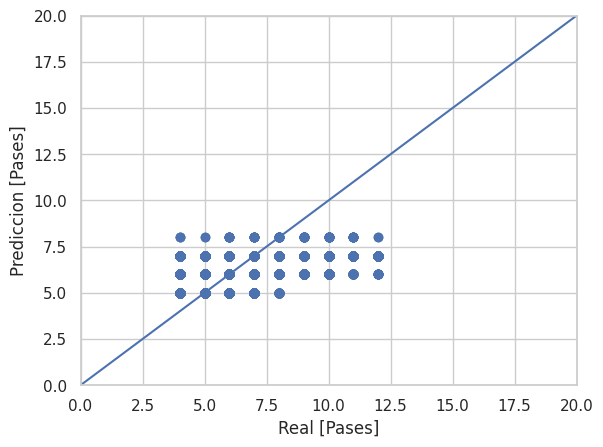

In [0]:
# Visualizar las predicciones
plt.scatter(y_test_rl, y_pred_test_rl)
plt.xlabel('Real [Pases]')
plt.ylabel('Prediccion [Pases]')
lims = [0, 20]
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims, lims)

#### 5.3 Arbol de decision Regressor

In [0]:
### Luego de Hacer el Feature Importances (Metodo de Envoltura) se identifico este conjunto de variables mas importantes
datos_total_escalados_dt =  datos_total_escalados[['tiempo_carga',
'capacidad_en_peso_equipo_carguio',
'densidad_inicial_poligono_creado_tn/m3',
'tonelaje_inicial_poligono_creado',
'elevacion_poligono_metros',
'capacidad_en_volumen_equipo_carguio_m3']]

# Supongamos que datos es tu DataFrame y has seleccionado tus características (X) y variable objetivo (y)
# Capacidad_peso = capacidad_volumen * densidad   O  capacidad_volumen = Capacidad_peso / densidad
X = datos_total_escalados_dt.values #Sale de los datos escalados

y = datos['numero_pases_carguio'].values # Reemplaza 'variable_objetivo' con el nombre de tu variable objetivo(sale de los datos originales)

In [0]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Supongamos que X es tu conjunto de características y y es tu variable objetivo (Número de Pases)
# Asegúrate de tener definidas estas variables antes de ejecutar el código

# Dividir el conjunto de datos en entrenamiento y prueba
X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo de árbol de decisión para regresión
model_arbol = DecisionTreeRegressor(max_depth=5,random_state=42)

# Entrenar el modelo
model_arbol.fit(X_train_dt, y_train_dt)

#----------------------------------------------------------------------------------------------------------------------
# Realizar predicciones en el conjunto de train
y_pred_dt_train = model_arbol.predict(X_train_dt)

# Redondear los valores de y_pred al entero más cercano
y_pred_dt_train = np.round(y_pred_dt_train).astype('int64')

#------------------------------------------------------------------------------------------------------------------------
# Realizar predicciones en el conjunto de prueba
y_pred_dt_test = model_arbol.predict(X_test_dt)

# Redondear los valores de y_pred al entero más cercano
y_pred_dt_test = np.round(y_pred_dt_test).astype('int64')

#-------------------------------------------------------------------------------------------------------------------------

# Visualizar el árbol de decisión (opcional)
# Nota: Necesitarás tener instalada la biblioteca graphviz y pydotplus para esto
# from sklearn.tree import export_graphviz
# import pydotplus
# dot_data = export_graphviz(modelo_arbol, out_file=None, feature_names=X.columns, filled=True, rounded=True)
# graph = pydotplus.graph_from_dot_data(dot_data)
# graph.write_png('arbol_decision.png')

# Medir el rendimiento del modelo
# error_absoluto_medio_dt = metrics.mean_absolute_error(y_test_dt, y_pred_dt)
# error_cuadratico_medio_dt = metrics.mean_squared_error(y_test_dt, y_pred_dt)
raiz_error_cuadratico_medio_dt_train = metrics.mean_squared_error(y_train_dt, y_pred_dt_train, squared=False) #squared=False indica a la #función que calcule la raíz cuadrada 
raiz_error_cuadratico_medio_dt_test = metrics.mean_squared_error(y_test_dt, y_pred_dt_test, squared=False)

# Imprimir métricas de rendimiento
# print(f'Error Absoluto Medio: {error_absoluto_medio_dt}')
# print(f'Error Cuadrático Medio: {error_cuadratico_medio_dt}')
print(f'Raíz del Error Cuadrático Medio Train: {raiz_error_cuadratico_medio_dt_train}')
print(f'Raíz del Error Cuadrático Medio Test: {raiz_error_cuadratico_medio_dt_test}')

Raíz del Error Cuadrático Medio Train: 1.0417714788701853
Raíz del Error Cuadrático Medio Test: 1.0504798024426154


/local_disk0/.ephemeral_nfs/cluster_libraries/python/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/local_disk0/.ephemeral_nfs/cluster_libraries/python/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Extraer mediante el metodo de envoltura las "Variables mas importantes para el modelo"

In [0]:
# Obtener las importancias de las características
feature_importances_dt = model_arbol.feature_importances_

# Crear un DataFrame para mostrar las importancias de las características junto con sus nombres
feature_importance_df_dt = pd.DataFrame({
    'Feature': datos_total_escalados_dt.columns,
    'Importance': feature_importances_dt
})

# Ordenar el DataFrame por importancia en orden descendente
feature_importance_df_dt = feature_importance_df_dt.sort_values(by='Importance', ascending=False)

# Mostrar las 10 características más importantes
print(feature_importance_df_dt.head(40))

                                  Feature  Importance
0                            tiempo_carga    0.931786
5  capacidad_en_volumen_equipo_carguio_m3    0.041540
2  densidad_inicial_poligono_creado_tn/m3    0.016531
1        capacidad_en_peso_equipo_carguio    0.006208
3        tonelaje_inicial_poligono_creado    0.002856
4               elevacion_poligono_metros    0.001079


In [0]:
# Obtener las importancias de las características
feature_importances_dt = model_arbol.feature_importances_

# Crear un DataFrame para mostrar las importancias de las características junto con sus nombres
feature_importance_df_dt = pd.DataFrame({
    'Feature': datos_total_escalados.columns,
    'Importance': feature_importances_dt
})

# Ordenar el DataFrame por importancia en orden descendente
feature_importance_df_dt = feature_importance_df_dt.sort_values(by='Importance', ascending=False)

# Mostrar las 10 características más importantes
print(feature_importance_df_dt.head(40))

#### 5.4 Random Forest 

In [0]:
### Luego de Hacer el Feature Importances (Metodo de Envoltura) se identifico este conjunto de variables mas importantes
datos_total_escalados_rf =  datos_total_escalados[['tiempo_carga','capacidad_en_volumen_equipo_carguio_m3',
'capacidad_en_peso_equipo_carguio',
'densidad_inicial_poligono_creado_tn/m3',
'tonelaje_inicial_poligono_creado',
'elevacion_poligono_metros',
'cantidad_equipos_espera_al_termino_carga_pala']]

# Supongamos que datos es tu DataFrame y has seleccionado tus características (X) y variable objetivo (y)
# Capacidad_peso = capacidad_volumen * densidad   O  capacidad_volumen = Capacidad_peso / densidad
X = datos_total_escalados_rf.values #Sale de los datos escalados

y = datos['numero_pases_carguio'].values # Reemplaza 'variable_objetivo' con el nombre de tu variable objetivo(sale de los datos originales)

In [0]:
# Importar librerías necesarias
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Supongamos que tienes un DataFrame llamado df con tus datos, y la columna objetivo es 'target'
# Asegúrate de tener las características adecuadas para entrenar el modelo

# Dividir el conjunto de datos en entrenamiento y prueba
# Dividir el conjunto de datos en entrenamiento y prueba
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el modelo de Random Forest
model_rf = RandomForestRegressor(n_estimators=20, max_depth=5 ,random_state=42)

# Entrenar el modelo
model_rf.fit(X_train_rf, y_train_rf)

#----------------------------------------------------------------------------------------------------------------------
# Realizar predicciones en el conjunto de train
y_pred_rf_train = model_rf.predict(X_train_rf)

# Redondear los valores de y_pred al entero más cercano
y_pred_rf_train = np.round(y_pred_rf_train).astype('int64')

#------------------------------------------------------------------------------------------------------------------------
# Realizar predicciones en el conjunto de prueba
y_pred_rf_test = model_rf.predict(X_test_rf)

# Redondear los valores de y_pred al entero más cercano
y_pred_rf_test = np.round(y_pred_rf_test).astype('int64')

#-------------------------------------------------------------------------------------------------------------------------

# Medir el rendimiento del modelo
# error_absoluto_medio_dt = metrics.mean_absolute_error(y_test_dt, y_pred_dt)
# error_cuadratico_medio_dt = metrics.mean_squared_error(y_test_dt, y_pred_dt)
raiz_error_cuadratico_medio_rf_train = metrics.mean_squared_error(y_train_rf, y_pred_rf_train, squared=False) #squared=False indica a la #función que calcule la raíz cuadrada 
raiz_error_cuadratico_medio_rf_test = metrics.mean_squared_error(y_test_rf, y_pred_rf_test, squared=False)

# Imprimir métricas de rendimiento
# print(f'Error Absoluto Medio: {error_absoluto_medio_dt}')
# print(f'Error Cuadrático Medio: {error_cuadratico_medio_dt}')
print(f'Raíz del Error Cuadrático Medio Train: {raiz_error_cuadratico_medio_rf_train}')
print(f'Raíz del Error Cuadrático Medio Test: {raiz_error_cuadratico_medio_rf_test}')

Raíz del Error Cuadrático Medio Train: 1.0391347994439073
Raíz del Error Cuadrático Medio Test: 1.0474548382589928


/local_disk0/.ephemeral_nfs/cluster_libraries/python/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/local_disk0/.ephemeral_nfs/cluster_libraries/python/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Extraer mediante el metodo de envoltura las "Variables mas importantes para el modelo"

In [0]:
# Obtener las importancias de las características
feature_importances_rf = model_rf.feature_importances_

# Crear un DataFrame para mostrar las importancias de las características junto con sus nombres
feature_importance_df_rf = pd.DataFrame({
    'Feature': datos_total_escalados_rf.columns,
    'Importance': feature_importances_rf
})

# Ordenar el DataFrame por importancia en orden descendente
feature_importance_df_rf = feature_importance_df_rf.sort_values(by='Importance', ascending=False)

# Mostrar las 10 características más importantes
print(feature_importance_df_rf.head(40))

                                         Feature  Importance
0                                   tiempo_carga    0.931334
1         capacidad_en_volumen_equipo_carguio_m3    0.027827
2               capacidad_en_peso_equipo_carguio    0.019416
3         densidad_inicial_poligono_creado_tn/m3    0.016215
4               tonelaje_inicial_poligono_creado    0.003550
5                      elevacion_poligono_metros    0.001564
6  cantidad_equipos_espera_al_termino_carga_pala    0.000093


In [0]:
# Obtener las importancias de las características
feature_importances_rf = model_rf.feature_importances_

# Crear un DataFrame para mostrar las importancias de las características junto con sus nombres
feature_importance_df_rf = pd.DataFrame({
    'Feature': datos_total_escalados.columns,
    'Importance': feature_importances_rf
})

# Ordenar el DataFrame por importancia en orden descendente
feature_importance_df_rf = feature_importance_df_rf.sort_values(by='Importance', ascending=False)

# Mostrar las 10 características más importantes
print(feature_importance_df_rf.head(40))

                                             Feature  Importance
10                                      tiempo_carga    0.921999
9             densidad_inicial_poligono_creado_tn/m3    0.015751
1                 radiohexagonocuchara_equipocarguio    0.015480
3                   capacidad_en_peso_equipo_carguio    0.015062
2             capacidad_en_volumen_equipo_carguio_m3    0.014934
7            tonelaje_camion_antes_cargaestabilizada    0.010073
0                   tonelaje_inicial_poligono_creado    0.003555
14                         elevacion_poligono_metros    0.000957
8                         tonelaje_segun_computadora    0.000780
5                              radio_locacion_metros    0.000772
4               tiempo_estimado_duracion_estado_pala    0.000413
20                                              PH01    0.000130
12     cantidad_equipos_espera_al_termino_carga_pala    0.000093
24                                               OXI    0.000000
19                       

#### 5.5 SVM (Support Vector Machine)

In [0]:
from sklearn.svm import SVR

# Dividir el conjunto de datos en entrenamiento y prueba
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo de SVM Regressor
model_svm = SVR(kernel='linear')  # Puedes ajustar los hiperparámetros según sea necesario
model_svm.fit(X_train_svm, y_train_svm)

# Realizar predicciones en el conjunto de prueba con SVM Regressor
y_pred_svm = model_svm.predict(X_test_svm)
y_pred_svm = np.round(y_pred_svm).astype('int64')

# Medir el rendimiento del modelo de SVM Regressor
error_absoluto_medio_svm = metrics.mean_absolute_error(y_test_svm, y_pred_svm)
error_cuadratico_medio_svm = metrics.mean_squared_error(y_test_svm, y_pred_svm)
raiz_error_cuadratico_medio_svm = metrics.mean_squared_error(y_test_svm, y_pred_svm, squared=False)

# Imprimir métricas de rendimiento de SVM Regressor
print("\nMétricas de rendimiento para SVM Regressor:")
print(f'Error Absoluto Medio: {error_absoluto_medio_svm}')
print(f'Error Cuadrático Medio: {error_cuadratico_medio_svm}')
print(f'Raíz del Error Cuadrático Medio: {raiz_error_cuadratico_medio_svm}')

#### 5.6 XGBoost: 

Construye árboles de manera secuencial. Cada árbol se entrena para corregir los errores de los árboles anteriores.

In [0]:
### Luego de Hacer el Feature Importances (Metodo de Envoltura) se identifico este conjunto de variables mas importantes
datos_total_escalados_xgb =  datos_total_escalados[['tiempo_carga','capacidad_en_volumen_equipo_carguio_m3',
'densidad_inicial_poligono_creado_tn/m3','elevacion_poligono_metros','tonelaje_inicial_poligono_creado',
'cantidad_equipos_espera_al_termino_carga_pala']]

# Supongamos que datos es tu DataFrame y has seleccionado tus características (X) y variable objetivo (y)
# Capacidad_peso = capacidad_volumen * densidad   O  capacidad_volumen = Capacidad_peso / densidad
X = datos_total_escalados_xgb.values #Sale de los datos escalados

y = datos['numero_pases_carguio'].values # Reemplaza 'variable_objetivo' con el nombre de tu variable objetivo(sale de los datos originales)

#### Metodo 1,  Sin convertir a ONNX

In [0]:
# Instalar las bibliotecas necesarias
# pip install xgboost scikit-learn matplotlib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
import matplotlib.pyplot as plt

# Supongamos que tienes un DataFrame llamado df con tus datos, y la columna objetivo es 'target'
# Asegúrate de tener las características adecuadas para entrenar el modelo

# Dividir el conjunto de datos en entrenamiento y prueba
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X, y, test_size=0.1, random_state=42)

# Crear el modelo de XGBoost
model_xgb = xgb.XGBRegressor(
    n_estimators=300,  # Número de árboles
    max_depth=15,  # Profundidad máxima de los árboles
    learning_rate=0.03, # tasa de aprendizaje, mas lento en ajustarse, pero necesitarias mas arboles
    subsample = 0.7,
    #reg_alpha = 0.5,
    reg_lambda = 2.5, # regulazirzacion L2 Ridge
    random_state=42 #Fijar la aleatoriedad durante el entrenamiento 
)

# Entrenar el modelo
model_xgb.fit(X_train_xgb, y_train_xgb)

#----------------------------------------------------------------------------------------------------------------------
# Realizar predicciones en el conjunto de train
y_pred_xgb_train = model_xgb.predict(X_train_xgb)

# Redondear los valores de y_pred al entero más cercano
y_pred_xgb_train = np.round(y_pred_xgb_train).astype('int64')

#------------------------------------------------------------------------------------------------------------------------
# Realizar predicciones en el conjunto de prueba
y_pred_xgb_test = model_xgb.predict(X_test_xgb)

# Redondear los valores de y_pred al entero más cercano
y_pred_xgb_test = np.round(y_pred_xgb_test).astype('int64')

#-------------------------------------------------------------------------------------------------------------------------

# Medir el rendimiento del modelo
# error_absoluto_medio_dt = metrics.mean_absolute_error(y_test_dt, y_pred_dt)
# error_cuadratico_medio_dt = metrics.mean_squared_error(y_test_dt, y_pred_dt)
raiz_error_cuadratico_medio_xgb_train = metrics.mean_squared_error(y_train_xgb, y_pred_xgb_train, squared=False) #squared=False indica a la #función que calcule la raíz cuadrada 
raiz_error_cuadratico_medio_xgb_test = metrics.mean_squared_error(y_test_xgb, y_pred_xgb_test, squared=False)

# Imprimir métricas de rendimiento
# print(f'Error Absoluto Medio: {error_absoluto_medio_dt}')
# print(f'Error Cuadrático Medio: {error_cuadratico_medio_dt}')
print(f'Raíz del Error Cuadrático Medio Train: {raiz_error_cuadratico_medio_xgb_train}')
print(f'Raíz del Error Cuadrático Medio Test: {raiz_error_cuadratico_medio_xgb_test}')

#### Metodo 2,  Con convertir a ONNX

In [0]:
import numpy as np  #Libreria para manejo de operaciones matematicas y matrices
#pip install onnxruntime -- Instalamos esta libreria
import onnxruntime as rt
#onnxruntime es una librería de ejecución de modelos ONNX (Open Neural Network Exchange) que permite cargar y
# ejecutar modelos ONNX en diferentes plataformas y dispositivos.
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
# from xgboost import XGBClassifier, XGBRegressor, DMatrix, train as train_xgb

#pip install --user skl2onnx -- Instala esta libreria como usuario, para no tener problemas de acceso
from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import convert_sklearn, to_onnx, update_registered_converter
from skl2onnx.common.shape_calculator import (
    calculate_linear_classifier_output_shapes,
    calculate_linear_regressor_output_shapes,
)
from onnxmltools.convert import convert_xgboost as convert_xgboost_booster
from onnxmltools.convert.xgboost.operator_converters.XGBoost import convert_xgboost
#skl2onnx es una librería que proporciona herramientas para convertir modelos sklearn a 
#formato ONNX. onnxmltools es otra librería que proporciona herramientas para convertir modelos xgboost a formato ONNX. 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
import matplotlib.pyplot as plt

# Registro del convertidor XGB CLASIFICADOR
# update_registered_converter(
#     XGBClassifier,
#     "XGBoostXGBClassifier",
#     calculate_linear_classifier_output_shapes,
#     convert_xgboost,
#     options={"nocl": [True, False], "zipmap": [True, False, "columns"]},
# )

# Registro del convertidor XGB REGRESSOR
update_registered_converter(
    xgb.XGBRegressor,
    "XGBoostXGBRegressor",
    calculate_linear_regressor_output_shapes,
    convert_xgboost
)

# Supongamos que tienes un DataFrame llamado df con tus datos, y la columna objetivo es 'target'
# Asegúrate de tener las características adecuadas para entrenar el modelo

# Dividir el conjunto de datos en entrenamiento y prueba
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X, y, test_size=0.1, random_state=42)

# Crear el modelo de XGBoost
model_pipe_xgb = Pipeline([("xgb", xgb.XGBRegressor(
    n_estimators=300,  # Número de árboles
    max_depth=15,  # Profundidad máxima de los árboles
    learning_rate=0.03, # tasa de aprendizaje, mas lento en ajustarse, pero necesitarias mas arboles
    subsample = 0.7,
    #reg_alpha = 0.5,
    reg_lambda = 2.5, # regulazirzacion L2 Ridge
    random_state=42 #Fijar la aleatoriedad durante el entrenamiento 
))])


# Entrenar el modelo
model_pipe_xgb.fit(X_train_xgb, y_train_xgb)

#----------------------------------------------------------------------------------------------------------------------
# Realizar predicciones en el conjunto de train
y_pred_xgb_train = model_pipe_xgb.predict(X_train_xgb)

# Redondear los valores de y_pred al entero más cercano
y_pred_xgb_train = np.round(y_pred_xgb_train).astype('int64')

#------------------------------------------------------------------------------------------------------------------------
# Realizar predicciones en el conjunto de prueba
y_pred_xgb_test = model_pipe_xgb.predict(X_test_xgb)

# Redondear los valores de y_pred al entero más cercano
y_pred_xgb_test = np.round(y_pred_xgb_test).astype('int64')

Medir el rendimiento del modelo

In [0]:
# Medir el rendimiento del modelo
# error_absoluto_medio_dt = metrics.mean_absolute_error(y_test_dt, y_pred_dt)
# error_cuadratico_medio_dt = metrics.mean_squared_error(y_test_dt, y_pred_dt)
raiz_error_cuadratico_medio_xgb_train = metrics.mean_squared_error(y_train_xgb, y_pred_xgb_train, squared=False) #squared=False indica a la #función que calcule la raíz cuadrada 
raiz_error_cuadratico_medio_xgb_test = metrics.mean_squared_error(y_test_xgb, y_pred_xgb_test, squared=False)

# Imprimir métricas de rendimiento
# print(f'Error Absoluto Medio: {error_absoluto_medio_dt}')
# print(f'Error Cuadrático Medio: {error_cuadratico_medio_dt}')
print(f'Raíz del Error Cuadrático Medio Train: {raiz_error_cuadratico_medio_xgb_train}')
print(f'Raíz del Error Cuadrático Medio Test: {raiz_error_cuadratico_medio_xgb_test}')

Raíz del Error Cuadrático Medio Train: 0.8538026018686038
Raíz del Error Cuadrático Medio Test: 1.0202719266517055


/local_disk0/.ephemeral_nfs/cluster_libraries/python/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/local_disk0/.ephemeral_nfs/cluster_libraries/python/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


#### Convertir el Modelo Pipe a ONNX

In [0]:
model_onnx = convert_sklearn(
    model_pipe_xgb,
    "xgboost_v1",
    [("input", FloatTensorType([None, X.shape[1]]))],
    target_opset={"": 12, "ai.onnx.ml": 2},
)

# And save.
with open("xgboost_v1.onnx", "wb") as f:
    f.write(model_onnx.SerializeToString())

Hacer una prediccion (Inferencia) con el Modelo ONNX convertido

In [0]:
sess = rt.InferenceSession("pipeline_xgboost.onnx", providers=["CPUExecutionProvider"])
pred_onx = sess.run(None, {"input": X[:6].astype(np.float32)})
print("predict", pred_onx[0])

predict [[6.9977655]
 [6.8193393]
 [7.2679205]
 [6.942699 ]
 [5.9028306]
 [7.515856 ]]


In [0]:
# from onnxmltools.convert import convert_xgboost as convert_xgboost_booster
# import onnxmltools

# # Convertir el modelo XGBoost a ONNX
# onnx_model = convert_xgboost_booster(model_xgb, 
#                                      'XGBoost model', 
#                                      initial_types=[('input',
#                                                       FloatTensorType([None, X.shape[1]]))])

# # Guardar el modelo ONNX en un archivo
# onnx_file = "xgboost_model.onnx"
# onnxmltools.utils.save_model(onnx_model, onnx_file)

Extraer mediante el metodo de envoltura las "Variables mas importantes para el modelo"

In [0]:
# Obtener las importancias de las características
feature_importances_xgb = model_xgb.feature_importances_

# Crear un DataFrame para mostrar las importancias de las características junto con sus nombres
feature_importance_df_xgb = pd.DataFrame({
    'Feature': datos_total_escalados_xgb.columns,
    'Importance': feature_importances_xgb
})

# Ordenar el DataFrame por importancia en orden descendente
feature_importance_df_xgb = feature_importance_df_xgb.sort_values(by='Importance', ascending=False)

# Mostrar las 10 características más importantes
print(feature_importance_df_xgb.head(40))

                                         Feature  Importance
0                                   tiempo_carga    0.386091
1         capacidad_en_volumen_equipo_carguio_m3    0.266026
3                      elevacion_poligono_metros    0.126685
2         densidad_inicial_poligono_creado_tn/m3    0.090266
4               tonelaje_inicial_poligono_creado    0.089423
5  cantidad_equipos_espera_al_termino_carga_pala    0.041509


In [0]:
# Obtener las importancias de las características
feature_importances_xgb = model_xgb.feature_importances_

# Crear un DataFrame para mostrar las importancias de las características junto con sus nombres
feature_importance_df_xgb = pd.DataFrame({
    'Feature': datos_total_escalados.columns,
    'Importance': feature_importances_xgb
})

# Ordenar el DataFrame por importancia en orden descendente
feature_importance_df_xgb = feature_importance_df_xgb.sort_values(by='Importance', ascending=False)

# Mostrar las 10 características más importantes
print(feature_importance_df_xgb.head(40))

                                             Feature  Importance
10                                      tiempo_carga    0.530803
1                 radiohexagonocuchara_equipocarguio    0.114758
2             capacidad_en_volumen_equipo_carguio_m3    0.047573
24                                               OXI    0.033131
9             densidad_inicial_poligono_creado_tn/m3    0.030401
22                                               TAJ    0.029434
12     cantidad_equipos_espera_al_termino_carga_pala    0.022232
7            tonelaje_camion_antes_cargaestabilizada    0.021099
0                   tonelaje_inicial_poligono_creado    0.020947
14                         elevacion_poligono_metros    0.020666
5                              radio_locacion_metros    0.019784
15                                              CF02    0.019614
4               tiempo_estimado_duracion_estado_pala    0.015158
20                                              PH01    0.014105
16                       

#### Tunnig de Hiperparametros del Modelo con GridSearch

In [0]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, train_test_split

X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X, y, test_size=0.1, random_state=42)

# Definir los parámetros para la búsqueda
param_grid = {
    'n_estimators': [100, 200, 300],  #Numero  de arboles que entrenaran
    'max_depth': [10, 15, 20],   #profundidad de cada arbol 
    'learning_rate': [0.01], #tasa de aprendizaje, valor más bajo significa que el modelo se ajusta más lentamente,que puede resultar un mejor rendimiento pero requiere un número mayor de árboles
    #'subsample': [0.7],  #Proporción de las muestras de entrenamiento utilizadas para construir cada árbol. Valores menores a 1.0 pueden prevenir el sobreajuste al introducir aleatoriedad  
    #'reg_alpha': [0, 0.1, 0.5]  #Regularización L1 (alpha o Lasso): Útil cuando se desea un modelo más simple y se sospecha que muchas características no son relevantes. ()
    #L1 Penaliza las características menos importantes y puede llevar algunas de ellas a tener un peso cero, esencialmente eliminándolas del modelo
    
    'reg_lambda': [1.5, 2],  # Regularización L2 (lambda o Ridge): Útil cuando se desea un modelo que sea robusto y evite el sobreajuste, pero sin eliminar completamente ninguna característica.
    # Penaliza las características con grandes coeficientes y reduce el impacto de las características menos importantes, sin eliminarlas por completo
}

model_xgb = xgb.XGBRegressor(random_state=42)

# Realizar la búsqueda en la cuadrícula con validación cruzada
grid_search = GridSearchCV(estimator=model_xgb, param_grid=param_grid, cv=2, n_jobs=-1, verbose=2)
#n_jobs=-1, se utilizan todos los núcleos de CPU disponibles en la máquina. Esto permite maximizar el uso de recursos del sistema para acelerar el proceso.
# validación cruzada (CV) divide el conjunto de datos en un número de particiones (folds), entrena el modelo en todas las particiones menos una y valida en la partición restante. Este proceso se repite para cada partición, asegurando que cada parte de los datos se utilice para validación exactamente una vez


grid_search.fit(X_train_xgb, y_train_xgb)

# Imprimir los mejores parámetros y el mejor score
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

# Evaluar el modelo en el conjunto de prueba
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_xgb)

In [0]:
# !pip list

#### 5.7 Red Neuronal MLP

In [0]:
# Aseguramos que los resultados sean "reproducibles" en cada ejecucion de tensorflow(pesos iniciales aleatorios)
import tensorflow as tf
import numpy as np

np.random.seed(42)
tf.random.set_seed(42)

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt

# Suponiendo que tienes tus datos X e y definidos antes de esta sección


#Dividir los sets de entrenamiento, validacion, test
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# train is now 75% of the entire data set (Dejas el 0.75 para entrenamiento 1-0.75 = 0.25 quedan libres)
x_train_mlp, x_test_mlp, y_train_mlp, y_test_mlp = train_test_split(X, y, test_size=1 - train_ratio)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set(de lo que sobro arriba 25%, sacas tu validacion y test)
x_val_mlp, x_test_mlp, y_val_mlp, y_test_mlp = train_test_split(x_test_mlp, y_test_mlp, test_size=test_ratio/(test_ratio + validation_ratio)) 

# ---  test_ratio/(test_ratio + validation_ratio) ---
#Esto significa que del 25% de datos restantes, el 40% será para el conjunto de prueba y el 60% para el conjunto de validación.
#Con esta proporción:
#x_val_lstm y y_val_lstm contendrán 0.60 * 0.25 = 0.15 del total original.
#x_test_lstm y y_test_lstm contendrán 0.40 * 0.25 = 0.10 del total original.


# Crear el modelo de la red neuronal
model_mlp = Sequential()
model_mlp.add(Dense(10, input_dim=X.shape[1], activation='relu')) #input_dim : numero de variables inputs
model_mlp.add(Dense(20, activation='relu'))
model_mlp.add(Dense(10, activation='relu'))
model_mlp.add(Dense(1, activation='linear'))

# Compilar el modelo
model_mlp.compile(loss='mean_squared_error', optimizer='adam')
model_mlp.summary()

# Entrenar el modelo y registrar las pérdidas
# Entrenar el modelo y registrar las pérdidas
history = model_mlp.fit(x_train_mlp, y_train_mlp, epochs=50, batch_size=5, verbose=2, validation_data=(x_val_mlp, y_val_mlp))

# Hacer predicciones en el conjunto de prueba
y_pred_mlp = model_mlp.predict(x_test_mlp)
y_pred_mlp = np.round(y_pred_mlp).astype('int64')

# Calcular el error cuadrático medio en el conjunto de prueba
mse = mean_squared_error(y_test_mlp, y_pred_mlp)
rmse = np.sqrt(mse)
print(f'Raíz del Error Cuadrático Medio en el conjunto de prueba: {rmse}')

Vizualizar las Perdidas(Para detectar si hay Overfitting)

In [0]:
# Graficar las pérdidas de entrenamiento y validación
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Curva de aprendizaje')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

Evaluar el rendimiento del Modelo en el Conj. de Entrenamiento y Validacion

In [0]:
# Hacer predicciones en el conjunto de ENTRENAMIENTO
y_train_pred_mlp = model_mlp.predict(x_train_mlp)

# Calcular el error cuadrático medio en el conjunto de entrenamiento
mse_train = mean_squared_error(y_train_mlp, y_train_pred_mlp)
rmse_train = np.sqrt(mse_train)
#----------------------------------------------------------------------------------------------------------------------------------------

# Hacer predicciones en el conjunto de VALIDACION
y_pred_val_mlp = model_mlp.predict(x_val_mlp)

# Calcular el error cuadrático medio en el conjunto de prueba
mse_val = mean_squared_error(y_val_mlp, y_pred_val_mlp)
rmse_val = np.sqrt(mse_val)

#--------------------------------------------------------------------------------------------------------------------------------------------
# Hacer predicciones en el conjunto de PRUEBA
y_pred_mlp = model_mlp.predict(x_test_mlp)

# Calcular el error cuadrático medio en el conjunto de prueba
mse_test = mean_squared_error(y_test_mlp, y_pred_mlp)
rmse_test = np.sqrt(mse_test)

print(f'Raíz del Error Cuadrático Medio en el conjunto de entrenamiento: {rmse_train}')
print(f'Raíz del Error Cuadrático Medio en el conjunto de entrenamiento: {rmse_val}')
print(f'Raíz del Error Cuadrático Medio en el conjunto de prueba: {rmse_test}')

#### Feature Importances in REDES NEURONALES

Metodo 1: Metodo Basado en Gradientes
- Gradiente: En términos matemáticos, el gradiente es una medida de cuánto cambia la salida de una función (en este caso, la red neuronal) en respuesta a cambios en sus entradas. Es un vector que apunta en la dirección del mayor aumento de la función.

- Importancia de las características: La importancia de una característica se puede estimar observando la magnitud del gradiente de la salida con respecto a esa característica. Una mayor magnitud del gradiente sugiere que pequeños cambios en esa característica tienen un gran impacto en la salida, lo que indica una mayor importancia.

- Calcular los gradientes: Una vez que la red neuronal está entrenada, se calculan los gradientes de la salida de la red con respecto a cada característica de entrada. Esto se hace usando el cálculo automático de derivadas, que es una capacidad estándar en bibliotecas de aprendizaje profundo como TensorFlow y PyTorch.

In [0]:
# model = tf.keras.models.load_model('your_model.h5') # Load your trained model

# X = np.load('your_input_data.npy') # Load your input data

# Convertir X(datos de caracteristicas MLP Red Neuronal Multicapa) a tensor de TensorFlow
input_tensor = tf.convert_to_tensor(X)

# Calcular gradientes de la salida con respecto a las entradas
with tf.GradientTape() as tape:
    tape.watch(input_tensor)
    output = model_mlp(input_tensor)

gradients = tape.gradient(output, input_tensor)

# Calcular la importancia de las características como la media absoluta de los gradientes
feature_importance = np.mean(np.abs(gradients.numpy()), axis=0)

# Obtener los nombres de las características del DataFrame original
feature_names = datos_total_escalados_mlp.columns

# Crear un DataFrame para asociar nombres de características con sus importancias
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

# Ordenar las características por importancia
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df

Metodo 2:  basado en pesos (weight-based methods) 
- se utiliza para estimar la importancia de las características en una red neuronal considerando los pesos o conexiones entre las neuronas
- Extraer Pesos: Obtener los pesos de las capas del modelo, especialmente de la primera capa si se está evaluando la importancia de las características de entrada.
-Calcular Importancia: Calcular la importancia de cada característica sumando los valores absolutos de sus pesos. Esto se basa en la idea de que los pesos con valores absolutos mayores tienen un impacto mayor en la salida del modelo.

In [0]:
# Obtener los pesos de las capas del modelo
weights = model_mlp.get_weights()

# Calcular la importancia de las características como la suma de los valores absolutos de los pesos de la primera capa
feature_importance = np.sum(np.abs(weights[0]), axis=1)

# Obtener los nombres de las características del DataFrame original
feature_names = datos_total_escalados_mlp.columns

# Crear un DataFrame para asociar nombres de características con sus importancias
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

# Ordenar las características por importancia
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("Importancia de las características:")
print(importance_df)

#### Convertir el Modelo a Tflite

1. Convertir desde la misma sesion y Configurar el convertidor TFLite

In [0]:
import tensorflow as tf

# Convertir desde la misma sesion y Configurar el convertidor TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model=model_mlp)

# Especificar las operaciones admitidas por el modelo TFLite
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]

# Deshabilitar la conversión de operaciones de lista de tensores
converter._experimental_lower_tensor_list_ops = False

# Convertir el modelo a TensorFlow Lite
model_tflite = converter.convert()

# Guardar el modelo TensorFlow Lite en disco
with open("model_mlp_v1.tflite", "wb") as f:
    f.write(model_tflite)

2. Convertir desde Cargar el modelo desde la ubicacion donde se guardo con "SavedModel de TensorFlow"

 Guardar el modelo entrenado

In [0]:
# Guardar el modelo entrenado

# Guardando todos los componentes del modelo (arquitectura, pesos, configuración de entrenamiento, estado del optimizador, etc.)
# SavedModel de TensorFlow
model_mlp.save("model_mlp_v1.h5")

In [0]:
import tensorflow as tf

# Cargar el modelo desde la ubicacion donde se guardo con "SavedModel de TensorFlow"
model_cargado = tf.keras.models.load_model('model_mlp_v1.h5')

# Convertir el modelo a formato .tflite
converter2 = tf.lite.TFLiteConverter.from_keras_model(model_cargado)

# Especificar el conjunto de operaciones admitidas
converter2.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # Operaciones TensorFlow Lite estándar (mayoría de los modelos, como convoluciones, activaciones, etc.)
    tf.lite.OpsSet.SELECT_TF_OPS      # Operaciones TensorFlow adicionales - Esto debes instalar en el Android Studio Gradle
]

# Convertir el modelo
tflite_model2 = converter2.convert()

# Guardar el modelo convertido en formato .tflite
with open('model_mlp_v1_2.tflite', 'wb') as f:
    f.write(tflite_model2)

#### Tunnig de Hiperparametros del Modelo de AI

1.Metodo de Grid Search 

In [0]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

# Suponiendo que tienes tus datos X e y definidos antes de esta sección

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear una función para construir el modelo
def create_model(optimizer='adam'):
    model_rnn = Sequential()
    model_rnn.add(Dense(10, input_dim=5, activation='relu'))
    model_rnn.add(Dense(20, activation='relu'))
    model_rnn.add(Dense(10, activation='relu'))
    model_rnn.add(Dense(1, activation='linear'))
    model_rnn.compile(loss='mean_squared_error', optimizer=optimizer)
    return model_rnn

# Crear el KerasRegressor
model_rnn = KerasRegressor(build_fn=create_model, verbose=0)

# Definir la búsqueda en cuadrícula de hiperparámetros
param_grid = {
    'batch_size': [10, 20],
    'epochs': [20, 40, 60, 100],
    'optimizer': ['adam', 'rmsprop']
}

# Realizar la búsqueda en cuadrícula
grid = GridSearchCV(estimator=model_rnn, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
grid_result = grid.fit(X_train_rnn, y_train_rnn)

# Resumir los resultados
print(f"Mejor puntuación (neg_mean_squared_error): {grid_result.best_score_}")
print(f"Mejores hiperparámetros: {grid_result.best_params_}")

# Obtener el mejor modelo
best_model = grid_result.best_estimator_

# Hacer predicciones en el conjunto de prueba
y_pred_rnn = best_model.predict(X_test_rnn)

# Calcular el error cuadrático medio en el conjunto de prueba
mse = mean_squared_error(y_test_rnn, y_pred_rnn)
# Calcular la raíz cuadrada del error cuadrático medio
rmse = np.sqrt(mse)

print(f'Raíz del Error Cuadrático Medio en el conjunto de prueba: {rmse}')

# Plot training & validation loss values
plt.plot(grid_result.best_estimator_.model.history.history['loss'])
plt.plot(grid_result.best_estimator_.model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


#### 5.8 Red Neuronal LSTM

In [0]:
## Luego de Hacer el Feature Importances (Metodo de Envoltura) se identifico este conjunto de variables mas importantes
datos_total_escalados_lstm =  datos_total_escalados[['tonelaje_inicial_poligono_creado',
'elevacion_poligono_metros',
'CF02','CF01', 'CF03', 'PH03', 'PH02', 'PH01', 'FR01',
'tiempo_ready_llegada_esperando',
'cantidad_equipos_espera_al_termino_carga_pala',
'densidad_inicial_poligono_creado_tn/m3']]

# Supongamos que datos es tu DataFrame y has seleccionado tus características (X) y variable objetivo (y)
# Capacidad_peso = capacidad_volumen * densidad   O  capacidad_volumen = Capacidad_peso / densidad
X = datos_total_escalados_lstm.values #Sale de los datos escalados

y = datos['numero_pases_carguio'].values # Reemplaza 'variable_objetivo' con el nombre de tu variable objetivo(sale de los datos originales)

In [0]:
X.shape[1]

12

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# En LSTM, debes mantener la secuencia al dividir en Train, Validation, Test

# Definir los porcentajes para cada conjunto (ajustados según tu necesidad)
train_ratio = 0.75  # 75% para entrenamiento
validation_ratio = 0.15  # 15% para validación
test_ratio = 0.10  # 10% para prueba

# Calcular los índices para dividir los datos
num_samples = len(X)
train_idx = int(train_ratio * num_samples)
val_idx = int((train_ratio + validation_ratio) * num_samples)

# Dividir los datos en conjuntos de entrenamiento, validación y prueba
x_train_lstm, y_train_lstm = X[:train_idx], y[:train_idx]
x_val_lstm, y_val_lstm = X[train_idx:val_idx], y[train_idx:val_idx]
x_test_lstm, y_test_lstm = X[val_idx:], y[val_idx:]


# Crear el modelo LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(30, activation='relu', input_shape=(1, X.shape[1]))) # X.shape[1] : Numero de variables input
model_lstm.add(Dense(50, activation='relu'))
model_lstm.add(Dense(30, activation='relu'))
model_lstm.add(Dense(15, activation='relu'))
model_lstm.add(Dense(1, activation='linear'))

# Compilar el modelo
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
model_lstm.summary()

# Entrenar el modelo y registrar las pérdidas input:(numero_muestras, bacthes, num_variables), output:(numero_muestras, bacthes, num_variables)
history = model_lstm.fit(x_train_lstm.reshape(-1, 1, X.shape[1]), y_train_lstm, epochs=50, batch_size=5, verbose=2, validation_data=(x_val_lstm.reshape(-1, 1, X.shape[1]), y_val_lstm))

# Hacer predicciones en el conjunto de prueba
y_pred_lstm = model_lstm.predict(x_test_lstm.reshape(-1, 1, X.shape[1]))
y_pred_lstm = np.round(y_pred_lstm).astype('int64')

# Calcular el error cuadrático medio en el conjunto de prueba
mse = mean_squared_error(y_test_lstm, y_pred_lstm)
rmse = np.sqrt(mse)
print(f'Raíz del Error Cuadrático Medio en el conjunto de prueba: {rmse}')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 30)                5160      
                                                                 
 dense_4 (Dense)             (None, 50)                1550      
                                                                 
 dense_5 (Dense)             (None, 30)                1530      
                                                                 
 dense_6 (Dense)             (None, 15)                465       
                                                                 
 dense_7 (Dense)             (None, 1)                 16        
                                                                 
Total params: 8721 (34.07 KB)
Trainable params: 8721 (34.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
49518/495

Vizualizar las Perdidas(Para detectar si hay Overfitting)

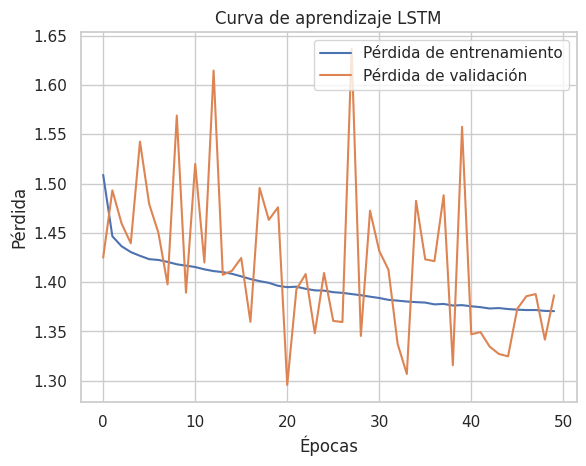

In [0]:
# Graficar las pérdidas de entrenamiento y validación
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Curva de aprendizaje LSTM')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

Evaluar el rendimiento del Modelo en el Conj. de Entrenamiento y Validacion

In [0]:
y_test_lstm.shape

(33012,)

In [0]:
# Hacer predicciones en el conjunto de ENTRENAMIENTO
y_train_pred_lstm = model_lstm.predict(x_train_lstm.reshape(-1, 1, X.shape[1]))

# Calcular el error cuadrático medio en el conjunto de entrenamiento
mse_train_lstm = mean_squared_error(y_train_lstm, y_train_pred_lstm)
rmse_train_lstm = np.sqrt(mse_train_lstm)
#----------------------------------------------------------------------------------------------------------------------------------------

# # Hacer predicciones en el conjunto de VALIDACION
y_val_pred_lstm = model_lstm.predict(x_val_lstm.reshape(-1, 1, X.shape[1]))

# # Calcular el error cuadrático medio en el conjunto de prueba
mse_val_lstm = mean_squared_error(y_val_lstm, y_val_pred_lstm)
rmse_val_lstm = np.sqrt(mse_val_lstm)

#--------------------------------------------------------------------------------------------------------------------------------------------
# Hacer predicciones en el conjunto de PRUEBA
y_test_pred_lstm = model_lstm.predict(x_test_lstm.reshape(-1, 1, X.shape[1]))

# Calcular el error cuadrático medio en el conjunto de prueba
mse_test_lstm = mean_squared_error(y_test_lstm, y_test_pred_lstm)
rmse_test_lstm = np.sqrt(mse_test_lstm)

print(f'Raíz del Error Cuadrático Medio en el conjunto de entrenamiento: {rmse_train_lstm}')
print(f'Raíz del Error Cuadrático Medio en el conjunto de entrenamiento: {rmse_val_lstm}')
print(f'Raíz del Error Cuadrático Medio en el conjunto de prueba: {rmse_test_lstm}')

1032/1032 [==============================] - 1s 1ms/step
Raíz del Error Cuadrático Medio en el conjunto de entrenamiento: 1.1680464415259866
Raíz del Error Cuadrático Medio en el conjunto de entrenamiento: 1.1775598070718
Raíz del Error Cuadrático Medio en el conjunto de prueba: 1.1280787811975381


#### Feature Importances in REDES NEURONALES

Metodo 1: Metodo Basado en Gradientes
- Gradiente: En términos matemáticos, el gradiente es una medida de cuánto cambia la salida de una función (en este caso, la red neuronal) en respuesta a cambios en sus entradas. Es un vector que apunta en la dirección del mayor aumento de la función.

- Importancia de las características: La importancia de una característica se puede estimar observando la magnitud del gradiente de la salida con respecto a esa característica. Una mayor magnitud del gradiente sugiere que pequeños cambios en esa característica tienen un gran impacto en la salida, lo que indica una mayor importancia.

- Calcular los gradientes: Una vez que la red neuronal está entrenada, se calculan los gradientes de la salida de la red con respecto a cada característica de entrada. Esto se hace usando el cálculo automático de derivadas, que es una capacidad estándar en bibliotecas de aprendizaje profundo como TensorFlow y PyTorch.

In [0]:
# model = tf.keras.models.load_model('your_model.h5') # Load your trained model

# X = np.load('your_input_data.npy') # Load your input data

# Expandir la dimensión de los datos de entrada para que sean compatibles con el modelo LSTM
#X_expanded = np.expand_dims(X, axis=1)  # (330118, 26) -> (330118, 1, 26)
X_reshape = X.reshape(-1, 1, X.shape[1])       # (330118, 26) -> (330118, 1, 26), X.shape[1] : Numero variables del modelo
# X_reshape.shape

# Convertir X(datos de caracteristicas LSTM) a tensor de TensorFlow
input_tensor = tf.convert_to_tensor(X_reshape)

# Calcular gradientes de la salida con respecto a las entradas
with tf.GradientTape() as tape:
    tape.watch(input_tensor)
    output = model_lstm(input_tensor)

gradients = tape.gradient(output, input_tensor)

# Reducir la dimensión del tensor de gradientes
gradients = tf.squeeze(gradients, axis=1)  # (330118, 1, 26) -> (330118, 26)

# Calcular la importancia de las características como la media absoluta de los gradientes
feature_importance = np.mean(np.abs(gradients.numpy()), axis=0)

# Obtener los nombres de las características del DataFrame original
feature_names = datos_total_escalados_lstm.columns

# Crear un DataFrame para asociar nombres de características con sus importancias
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

# Ordenar las características por importancia
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df

,Feature,Importance
0,tonelaje_inicial_poligono_creado,4.593964
1,elevacion_poligono_metros,2.433526
3,CF01,2.162164
11,densidad_inicial_poligono_creado_tn/m3,1.949165
5,PH03,1.924106
6,PH02,1.710187
4,CF03,1.243561
9,tiempo_ready_llegada_esperando,1.013851
2,CF02,0.930882
7,PH01,0.810890


Metodo 2:  basado en pesos (weight-based methods) 
- se utiliza para estimar la importancia de las características en una red neuronal considerando los pesos o conexiones entre las neuronas
- Extraer Pesos: Obtener los pesos de las capas del modelo, especialmente de la primera capa si se está evaluando la importancia de las características de entrada.
-Calcular Importancia: Calcular la importancia de cada característica sumando los valores absolutos de sus pesos. Esto se basa en la idea de que los pesos con valores absolutos mayores tienen un impacto mayor en la salida del modelo.

In [0]:
# Obtener los pesos de las capas del modelo
weights = model_lstm.get_weights()

# Calcular la importancia de las características como la suma de los valores absolutos de los pesos de la primera capa
feature_importance = np.sum(np.abs(weights[0]), axis=1)

# Obtener los nombres de las características del DataFrame original
feature_names = datos_total_escalados_lstm.columns

# Crear un DataFrame para asociar nombres de características con sus importancias
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

# Ordenar las características por importancia
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("Importancia de las características:")
print(importance_df)

Importancia de las características:
                                          Feature  Importance
0                tonelaje_inicial_poligono_creado  257.305176
1                       elevacion_poligono_metros  107.706566
9                  tiempo_ready_llegada_esperando   93.405121
11         densidad_inicial_poligono_creado_tn/m3   72.263901
6                                            PH02   66.423996
3                                            CF01   59.734280
4                                            CF03   56.993782
5                                            PH03   54.584824
10  cantidad_equipos_espera_al_termino_carga_pala   54.239525
7                                            PH01   47.244762
2                                            CF02   42.670277
8                                            FR01   13.806595


Metodo 3: Extracción y Procesamiento de Pesos de Todas las Capas

In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd

# # Cargar el modelo previamente entrenado
# model = tf.keras.models.load_model('your_model.h5')

# Obtener los pesos de las capas del modelo
weights = model_rnn.get_weights()

# Inicializar una lista para almacenar la importancia de cada característica
num_features = weights[0].shape[0]
total_importance = np.zeros(num_features)

# Calcular la importancia de cada característica a través de todas las capas
for i in range(0, len(weights), 2):  # Saltamos cada 2 para solo tomar los pesos y no los biases
    layer_weights = weights[i]
    if len(layer_weights.shape) == 2:  # Asegurar que es una capa densamente conectada
        layer_importance = np.sum(np.abs(layer_weights), axis=1)
        total_importance += layer_importance

# Obtener los nombres de las características del DataFrame original
feature_names = datos_total_escalados.columns

# Crear un DataFrame para asociar nombres de características con sus importancias
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': total_importance
})

# Ordenar las características por importancia
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("Importancia de las características:")
print(importance_df) 

Importancia de las características:
                                             Feature  Importance
0                   tonelaje_inicial_poligono_creado  154.245728
12     cantidad_equipos_espera_al_termino_carga_pala   62.158958
5                              radio_locacion_metros   59.942360
20                                              PH01   57.490532
9             densidad_inicial_poligono_creado_tn/m3   56.594673
6                     tiempo_ready_llegada_esperando   55.652679
23                                               SUL   50.334808
24                                               OXI   44.472168
14                         elevacion_poligono_metros   40.281616
18                                              PH03   35.733707
19                                              PH02   33.260403
7            tonelaje_camion_antes_cargaestabilizada   31.519482
22                                               TAJ   30.736492
25                                        NoDefinido  

#### Convertir el Modelo a Tflite

1. Convertir desde la misma sesion y Configurar el convertidor TFLite

In [0]:
import tensorflow as tf

# Convertir desde la misma sesion y Configurar el convertidor TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model=model_lstm)

# Especificar las operaciones admitidas por el modelo TFLite
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]

# Deshabilitar la conversión de operaciones de lista de tensores
#(converter._experimental_lower_tensor_list_ops = True): Significa que el convertidor intentará simplificar las operaciones de listas de tensores a operaciones más primitivas y compatibles con TensorFlow Lite (TFLite).
#(converter._experimental_lower_tensor_list_ops = False): Significa que el convertidor no realizará esta simplificación, y las operaciones de listas de tensores se mantendrán en su forma original, lo cual puede resultar en incompatibilidades con TFLite.
converter._experimental_lower_tensor_list_ops = False

# Convertir el modelo a TensorFlow Lite
model_tflite = converter.convert()

# Guardar el modelo TensorFlow Lite en disco
with open("model_lstm_v1.tflite", "wb") as f:
    f.write(model_tflite)

INFO:tensorflow:Assets written to: /tmp/tmpwsmst_aj/assets


INFO:tensorflow:Assets written to: /tmp/tmpwsmst_aj/assets


2. Convertir desde Cargar el modelo desde la ubicacion donde se guardo con "SavedModel de TensorFlow"

 Guardar el modelo entrenado

In [0]:
# Guardar el modelo entrenado

# Guardando todos los componentes del modelo (arquitectura, pesos, configuración de entrenamiento, estado del optimizador, etc.)
# SavedModel de TensorFlow
model_lstm.save("model_lstm_v1.h5")

/local_disk0/.ephemeral_nfs/cluster_libraries/python/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [0]:
import tensorflow as tf

# Cargar el modelo desde la ubicacion donde se guardo con "SavedModel de TensorFlow"
model_cargado = tf.keras.models.load_model('model_mlp_v1.h5')

# Convertir el modelo a formato .tflite
converter2 = tf.lite.TFLiteConverter.from_keras_model(model_cargado)

# Especificar el conjunto de operaciones admitidas
converter2.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # Operaciones TensorFlow Lite estándar (mayoría de los modelos, como convoluciones, activaciones, etc.)
    tf.lite.OpsSet.SELECT_TF_OPS      # Operaciones TensorFlow adicionales - Esto debes instalar en el Android Studio Gradle
]

#(converter._experimental_lower_tensor_list_ops = True): Significa que el convertidor intentará simplificar las operaciones de listas de tensores a operaciones más primitivas y compatibles con TensorFlow Lite (TFLite).
#(converter._experimental_lower_tensor_list_ops = False): Significa que el convertidor no realizará esta simplificación, y las operaciones de listas de tensores se mantendrán en su forma original, lo cual puede resultar en incompatibilidades con TFLite.
converter._experimental_lower_tensor_list_ops = False

# Convertir el modelo
tflite_model2 = converter2.convert()

# Guardar el modelo convertido en formato .tflite
with open('model_mlp_v1_2.tflite', 'wb') as f:
    f.write(tflite_model2)

#### 6. Armando los BaseFinal, con los valores predichos de cada Modelo, y tambien medir el impacto con productividades

In [0]:
# Agregar las predicciones como una columna adicional al conjunto de prueba
df_resultados_models = X_test_gen.copy()
df_resultados_models['Numero_pases_real'] = y_test_gen
df_resultados_models['Numero_pases_reglineal'] = y_pred_rl
df_resultados_models['Numero_pases_arboldecision'] = y_pred_dt
df_resultados_models['Numero_pases_rforest'] = y_pred_rf
df_resultados_models['Numero_pases_xgb'] = y_pred_xgb
df_resultados_models['Numero_pases_rnn'] = y_pred_rnn

#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#Regresion Lineal
df_resultados_models['Diferencia_Pases_rl'] = df_resultados_models['Numero_pases_reglineal'] - df_resultados_models['Numero_pases_real']
df_resultados_models['tonelaje_segun_computadora_rl'] = (df_resultados_models['tonelaje_segun_computadora']) + (df_resultados_models['Diferencia_Pases_rl']*df_resultados_models['capacidad_en_peso_equipo_carguio'])


#Arbol de decision
df_resultados_models['Diferencia_Pases_dt'] = df_resultados_models['Numero_pases_arboldecision'] - df_resultados_models['Numero_pases_real']
df_resultados_models['tonelaje_segun_computadora_dt'] = (df_resultados_models['tonelaje_segun_computadora']) + (df_resultados_models['Diferencia_Pases_dt']*df_resultados_models['capacidad_en_peso_equipo_carguio'])


# Random Forest 
df_resultados_models['Diferencia_Pases_rf'] = df_resultados_models['Numero_pases_rforest'] - df_resultados_models['Numero_pases_real']
df_resultados_models['tonelaje_segun_computadora_rf'] = (df_resultados_models['tonelaje_segun_computadora']) + (df_resultados_models['Diferencia_Pases_rf']*df_resultados_models['capacidad_en_peso_equipo_carguio'])


# XGB (eXtreme Gradient Boosting)
df_resultados_models['Diferencia_Pases_xgb'] = df_resultados_models['Numero_pases_xgb'] - df_resultados_models['Numero_pases_real']
df_resultados_models['tonelaje_segun_computadora_xgb'] = (df_resultados_models['tonelaje_segun_computadora']) + (df_resultados_models['Diferencia_Pases_xgb']*df_resultados_models['capacidad_en_peso_equipo_carguio'])

# RNN (Redes Neuronales LSTM)
df_resultados_models['Diferencia_Pases_rnn'] = df_resultados_models['Numero_pases_rnn'] - df_resultados_models['Numero_pases_real']
df_resultados_models['tonelaje_segun_computadora_rnn'] = (df_resultados_models['tonelaje_segun_computadora']) + (df_resultados_models['Diferencia_Pases_rnn']*df_resultados_models['capacidad_en_peso_equipo_carguio'])


df_resultados_models.head(10)

## Part 1. Train a classification model

### MLflow Tracking
[MLflow tracking](https://www.mlflow.org/docs/latest/tracking.html) allows you to organize your machine learning training code, parameters, and models. 

You can enable automatic MLflow tracking by using [*autologging*](https://www.mlflow.org/docs/latest/tracking.html#automatic-logging).

In [0]:
# Establecer semillas en NumPy y TensorFlow
np.random.seed(42)
tf.random.set_seed(42)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(X, y, test_size=0.2, random_state=42)

Modelo 1 - Redes LSTM

In [0]:
#Librerias para redes neuronales(LSTM)
from tensorflow.keras.layers import Dense, LSTM
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Normalization
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Establecer semillas en NumPy y TensorFlow
np.random.seed(42)
tf.random.set_seed(42)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(X, y, test_size=0.2, random_state=42)
#X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(X_array, y_array, test_size=0.2, random_state=42)

model_rnn = Sequential()
# La forma de entrada para LSTM debe ser (n_timesteps, n_features)
model_rnn.add(LSTM(30, activation='relu', input_shape=(1, 5)))  #  (n_samples, n_pasos, n_variables)
# Agregar capas Dense según sea necesario
model_rnn.add(Dense(60, activation='relu'))
model_rnn.add(Dense(30, activation='relu'))
model_rnn.add(Dense(15, activation='relu'))
# Capa de salida
model_rnn.add(Dense(1, activation='linear'))
#-----------------------------------------------------------------------------------------------------------------------------------------

# Compilar el modelo
model_rnn.compile(loss='mean_squared_error', optimizer='adam')
# Imprimir un resumen del modelo
model_rnn.summary()

# Entrenar el modelo
history = model_rnn.fit(X_train_rnn.reshape(-1, 1, 5), y_train_rnn, epochs=1, validation_data=(X_test_rnn.reshape(-1, 1, 5),y_test_rnn), batch_size=5, verbose=1)

# VALIDACION 1
# Obtener la pérdida en el conjunto de entrenamiento y el conjunto de validación
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Calcular el RMSE en el conjunto de entrenamiento y el conjunto de validación
train_rmse = np.sqrt(train_loss)
val_rmse = np.sqrt(val_loss)

# VALIDACION 2
# Hacer predicciones en el conjunto de prueba
y_pred_rnn = model_rnn.predict(X_test_rnn.reshape(-1, 1, 5)) # (n_samples, n_pasos, n_variables)

# Redondear los valores de y_pred al entero más cercano
y_pred_rnn = np.round(y_pred_rnn).astype('int64')

# Calcular el error cuadrático medio en el conjunto de prueba
mse = mean_squared_error(y_test_rnn, y_pred_rnn)
# Calcular la raíz cuadrada del error cuadrático medio
rmse = np.sqrt(mse)
print(f'Raíz del Error Cuadrático Medio en el conjunto de prueba: {rmse}')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30)                4320      
                                                                 
 dense (Dense)               (None, 60)                1860      
                                                                 
 dense_1 (Dense)             (None, 30)                1830      
                                                                 
 dense_2 (Dense)             (None, 15)                465       
                                                                 
 dense_3 (Dense)             (None, 1)                 16        
                                                                 
Total params: 8491 (33.17 KB)
Trainable params: 8491 (33.17 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2024/03/19 20:56:22 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f32cc87c8d654fd1a98062b763ca3258', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


  4393/117796 [>.............................] - ETA: 3:41 - loss: 1.2564

*** WARNING: max output size exceeded, skipping output. ***

117774/117796 [============================>.] - ETA: 0s - loss: 1.1342

/local_disk0/.ephemeral_nfs/cluster_libraries/python/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 195ms/step
INFO:tensorflow:Assets written to: /local_disk0/repl_tmp_data/ReplId-53528-615ab-1c55e-d/tmp8461cdw0/model/data/model/assets


INFO:tensorflow:Assets written to: /local_disk0/repl_tmp_data/ReplId-53528-615ab-1c55e-d/tmp8461cdw0/model/data/model/assets
2024/03/19 21:00:50 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/databricks/python/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


Uploading artifacts:   0%|          | 0/12 [00:00<?, ?it/s]

2024/03/19 21:00:50 INFO mlflow.store.artifact.cloud_artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false


Uploading artifacts:   0%|          | 0/2 [00:00<?, ?it/s]

4602/4602 [==============================] - 5s 1ms/step
Raíz del Error Cuadrático Medio en el conjunto de prueba: 1.1679133632128265


  3018/117796 [..............................] - ETA: 5:29 - loss: 1.6606

*** WARNING: max output size exceeded, skipping output. ***

117792/117796 [============================>.] - ETA: 0s - loss: 1.1446

/local_disk0/.ephemeral_nfs/cluster_libraries/python/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 299ms/step
INFO:tensorflow:Assets written to: /local_disk0/repl_tmp_data/ReplId-1d958-694ec-2be8a-8/tmp9ukw151v/model/data/model/assets


INFO:tensorflow:Assets written to: /local_disk0/repl_tmp_data/ReplId-1d958-694ec-2be8a-8/tmp9ukw151v/model/data/model/assets
2024/03/26 16:37:06 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/databricks/python/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


Uploading artifacts:   0%|          | 0/12 [00:00<?, ?it/s]

2024/03/26 16:37:06 INFO mlflow.store.artifact.cloud_artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false


Uploading artifacts:   0%|          | 0/2 [00:00<?, ?it/s]

2024/03/26 16:37:07 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /local_disk0/repl_tmp_data/ReplId-1d958-694ec-2be8a-8/tmptut_vjv0/model/data/model/assets


INFO:tensorflow:Assets written to: /local_disk0/repl_tmp_data/ReplId-1d958-694ec-2be8a-8/tmptut_vjv0/model/data/model/assets
2024/03/26 16:37:16 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.11.1/models.html#set-signature-on-logged-model for instructions on setting a model signature on your logged model.


Uploading artifacts:   0%|          | 0/12 [00:00<?, ?it/s]

2024/03/26 16:37:16 INFO mlflow.store.artifact.cloud_artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false


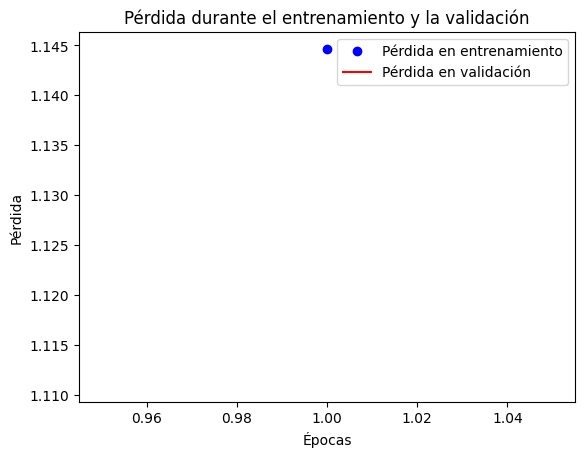

In [0]:
import mlflow
import mlflow.keras
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Establecer semillas en NumPy y TensorFlow
np.random.seed(42)
tf.random.set_seed(42)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(X, y, test_size=0.2, random_state=42)

#MLflow podra registrar automáticamente métricas, parámetros y el modelo generado durante el entrenamiento
mlflow.tensorflow.autolog()  # Keras y TensorFlow

# Entrenar el modelo
with mlflow.start_run(run_name='experimento_MLOPS_V1'):  #Iniciliza un nuevo experimento de MlFlow
    # Definir y compilar el modelo
    model_rnn = Sequential()
    model_rnn.add(LSTM(30, activation='relu', input_shape=(1, 5)))
    model_rnn.add(Dense(60, activation='relu'))
    model_rnn.add(Dense(30, activation='relu'))
    model_rnn.add(Dense(15, activation='relu'))
    model_rnn.add(Dense(1, activation='linear'))

    model_rnn.compile(loss='mean_squared_error', optimizer='adam')

    # Entrenar el modelo y guardar el historial del entrenamiento
    history = model_rnn.fit(X_train_rnn.reshape(-1, 1, 5), y_train_rnn, epochs=1, validation_data=(X_test_rnn.reshape(-1, 1, 5), y_test_rnn), batch_size=5, verbose=1)

    # Save the run information to register the model later
    #kerasURI = run.info.artifact_uri

    # Registrar los parámetros del modelo
    mlflow.log_params({
        "input_shape": (1, 5),
        "lstm_units": 30,
        "dense_layers": [60, 30, 15],
        "activation": "relu",
        "optimizer": "adam",
        "loss_function": "mean_squared_error",
        "epochs": 1,
        "batch_size": 5
    })

    # Registrar la estructura del modelo en MLflow
    #mlflow.keras.log_model(model_rnn, "keras_tf_v1")

    # VALIDACION 
    # Obtener la pérdida en el conjunto de entrenamiento y el conjunto de validación
    train_loss = history.history['loss']
    test_loss = history.history['val_loss']

    # Calcular el RMSE en el conjunto de entrenamiento y el conjunto de validación
    train_rmse = np.sqrt(train_loss)
    test_rmse = np.sqrt(test_loss)

    # Registro de métricas de RMSE
    mlflow.log_metric("train_RMSE", train_rmse[-1])  # Se registra el último valor de RMSE del conjunto de entrenamiento
    mlflow.log_metric("test_RMSE", test_rmse[-1])      # Se registra el último valor de RMSE del conjunto de validación
    
    # Crear gráfico de pérdida durante el entrenamiento
    epochs = range(1, len(train_loss) + 1)
    plt.plot(epochs, train_loss, 'bo', label='Pérdida en entrenamiento')
    plt.plot(epochs, test_loss, 'r', label='Pérdida en validación')
    plt.title('Pérdida durante el entrenamiento y la validación')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.savefig("kerasplotv3.png")
    mlflow.log_artifact("kerasplotv3.png")

In [0]:
model_path

'dbfs:/databricks/mlflow-tracking/8323b80e926241ee8763b7dc43085602/19ddc048483b4e6d867de17ca57598ea/artifacts/keras_tf_v3'

#### Register to Model Registry

In [0]:
model_name = "Example_rnn"                                  #nombre que se le dara al modelo que registraremos en el MlFlow Registry
model_uri = f"runs:/ed91e81d7ca644728f3e223fa3cfac92/model" #identificador unico del experimento a registrar en Mlflow
registered_model_version = mlflow.register_model(model_uri, model_name)

Successfully registered model 'Example_rnn'.
2024/03/26 18:18:28 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Example_rnn, version 1
Created version '1' of model 'Example_rnn'.


#### Load from Model Registry 

In [0]:
import numpy as np
import mlflow

client = mlflow.tracking.MlflowClient() 
model_name = "Example_rnn"

model_info = client.get_registered_model(model_name)
model_version = model_info.latest_versions[0].version #Ultima version del modelo en MlFlow Registry
#model_version = registered_model_version.version

model = mlflow.pyfunc.load_model(model_uri=f"models:/{model_name}/{model_version}")

# Supongamos que tienes tus datos de entrada en una lista
input_data = np.array([[12, 35, 129, 48, 129]])

# # Convertir los datos de entrada al tipo de datos float64
input_data = input_data.astype(np.float64)

# # Aumentamos a 3dimensiones los datos de entrada para que tengan la forma (None, 1, 5)
input_data = np.reshape(input_data, (input_data.shape[0], 1, input_data.shape[1]))

# # Realiza la predicción utilizando el modelo
model.predict(input_data)

2024/03/26 23:02:02 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false


1/1 [==============================] - 0s 287ms/step


array([[3.0850453]], dtype=float32)

### Load model without experiments

In [0]:
model_uri = f"runs:/ed91e81d7ca644728f3e223fa3cfac92/model"
model = mlflow.pyfunc.load_model(model_uri)

2024/03/26 19:56:16 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false


#### Actualizar el modelo y tener una nueva version del Modelo de MlFlow Registry

In [0]:
import mlflow

# Definir el nombre del modelo y la nueva URI del modelo (para la versión 2)
model_name = "Example_rnn"
new_model_uri = 'runs:/3fdcef4bd83943ec9dc2188bc13045f4/model'  # Ejemplo de nueva URI del modelo

# Registrar la nueva versión del modelo con la misma nombre pero con una nueva URI
registered_model_version = mlflow.register_model(new_model_uri, model_name)

# Si deseas, puedes obtener el ID de la nueva versión del modelo registrado
new_version_id = registered_model_version.version
new_version_id

Registered model 'Example_rnn' already exists. Creating a new version of this model...
2024/03/26 20:15:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Example_rnn, version 2
Created version '2' of model 'Example_rnn'.


'2'

#### Validacion del Modelo antes de pasasr a Staging

In [0]:
#Obtener el modelo  in trancision, su nombre y version por el Webbook
#model_name, model_version = fech_webbook_data()
import mlflow
# Interactuar con el servidor de MLflow
client = mlflow.tracking.MlflowClient()  
model_name = "Example_rnn"

model_info = client.get_registered_model(model_name)
model_version = model_info.latest_versions[0].version #Ultima version del modelo en MlFlow Registry

models_details = client.get_model_version(model_name, model_version)
run_info = client.get_run(run_id=models_details.run_id)

In [0]:
run_info

<Run: data=<RunData: metrics={'loss': 1.1630303859710693,
 'test_RMSE': 1.0531656093295292,
 'train_RMSE': 1.0784388651987045,
 'val_loss': 1.1091578006744385,
 'validation_loss': 1.1091578006744385}, params={'activation': 'relu',
 'batch_size': '5',
 'class_weight': 'None',
 'dense_layers': '[60, 30, 15]',
 'epochs': '1',
 'initial_epoch': '0',
 'input_shape': '(1, 5)',
 'loss_function': 'mean_squared_error',
 'lstm_units': '30',
 'max_queue_size': '10',
 'opt_amsgrad': 'False',
 'opt_beta_1': '0.9',
 'opt_beta_2': '0.999',
 'opt_clipnorm': 'None',
 'opt_clipvalue': 'None',
 'opt_ema_momentum': '0.99',
 'opt_ema_overwrite_frequency': 'None',
 'opt_epsilon': '1e-07',
 'opt_global_clipnorm': 'None',
 'opt_is_legacy_optimizer': 'False',
 'opt_jit_compile': 'False',
 'opt_learning_rate': '0.001',
 'opt_name': 'Adam',
 'opt_use_ema': 'False',
 'opt_weight_decay': 'None',
 'optimizer': 'adam',
 'sample_weight': 'None',
 'shuffle': 'True',
 'steps_per_epoch': 'None',
 'use_multiprocessing': 

#### Validacion de la prediccion

In [0]:
from databricks.feature_store import FeatureStoreClient

---------------------------------------------------------------------------
ModuleNotFoundError                       Traceback (most recent call last)
File <command-4480643514565427>, line 1
----> 1 from databricks.feature_store import FeatureStoreClient

ModuleNotFoundError: No module named 'databricks.feature_store'

In [0]:
from databricks.feature_store import FeatureStoreClient

fs = FeatureStoreClient()

#Leer de Feature Store 
data_source = run_info.data.tags['db_table']
features = fs.read_table(data_source)

#Load model as a spark UDF
model_uri = f"models:/{model_name}/{model_version}"
loaded_model = mlflow.pyfunc.spark_udf(spark, model_uri=model_uri)

#Selecciona las columnas de la tabla de caracteristicas, por el esquema input del modelo
input_columns_names = loaded_model.metadata.get_input_schema().input_names()

#Predict in spark dataframe
try:
    display(features.withColumn('predictions', loaded_model(*input_columns_names)))
    client.set_model_version_tag(name=model_name, version=model_version, key="predicts", value=1)
except Exception:
    print("No se puede predecir las caracteristicas,")
    client.set_model_version_tag(name=model_name, version=model_version, key="predicts", value=0)
    pass


---------------------------------------------------------------------------
ModuleNotFoundError                       Traceback (most recent call last)
File <command-4480643514565426>, line 1
----> 1 from databricks.feature_store import FeatureStoreClient
      3 fs = FeatureStoreClient()
      5 #Leer de Feature Store 

ModuleNotFoundError: No module named 'databricks.feature_store'

In [0]:
import mlflow

# Nombre del modelo registrado
model_name = "MLops_kerastf_v3"

# Crear una instancia del cliente de MLflow
client = mlflow.tracking.MlflowClient()

# Obtener la información sobre el modelo
model_info = client.get_registered_model(model_name)

In [0]:
model_info

<RegisteredModel: aliases={}, creation_timestamp=1711048792489, description='', last_updated_timestamp=1711403608444, latest_versions=[<ModelVersion: aliases=[], creation_timestamp=1711403608444, current_stage='None', description='', last_updated_timestamp=1711403610490, name='MLops_kerastf_v3', run_id='', run_link='', source='dbfs:/databricks/mlflow-tracking/8323b80e926241ee8763b7dc43085602/19ddc048483b4e6d867de17ca57598ea/artifacts/keras_tf_v3', status='READY', status_message='', tags={}, user_id='bryan.inche@ms4m.com', version='2'>], name='MLops_kerastf_v3', tags={}>

In [0]:
# Estado al que deseas cambiar el modelo (p. ej., "Production", "Staging", "Archived")
new_stage = "None"

# Versión específica que deseas cambiar de estado
#target_version = model_info.latest_versions[0].version # ultima version del modelo registrado en mlflow registry
target_version = 1


# Cambiar el estado del modelo
client.transition_model_version_stage(
    name=model_name,
    version = target_version,  #
    stage=new_stage
)


/root/.ipykernel/1260/command-4490127842409193-3176234234:10: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.11.1/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


<ModelVersion: aliases=[], creation_timestamp=1711048792722, current_stage='None', description='', last_updated_timestamp=1711408717844, name='MLops_kerastf_v3', run_id='', run_link='', source='dbfs:/databricks/mlflow-tracking/8323b80e926241ee8763b7dc43085602/186379e93c684b8dbe8e65cb53cf653a/artifacts/keras_tf_v3', status='READY', status_message='', tags={}, user_id='4044096405736964', version='1'>

In [0]:
# Estado al que deseas cambiar el modelo (p. ej., "Production", "Staging", "Archived")
new_stage = "Production"

# Cambiar el estado del modelo
client.transition_model_version_stage(
    name=model_name,
    version=model_info.latest_versions[0].version,
    stage=new_stage
)

In [0]:
import matplotlib.pyplot as plt
# Crear gráfico de pérdida durante el entrenamiento
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'bo', label='Pérdida en entrenamiento')
plt.plot(epochs, val_loss, 'r', label='Pérdida en validación')
plt.title('Pérdida durante el entrenamiento y la validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

Modelo 2 : Redes Tradicionales

In [0]:
#Librerias para redes neuronales(LSTM)
from tensorflow.keras.layers import Dense, LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Normalization
from tensorflow.keras.optimizers import Adam
#from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# 3. Construccion del modelo de RED NEURONAL
# Aseguramos que los resultados sean "reproducibles" en cada ejecucion de tensorflow(pesos iniciales aleatorios)
np.random.seed(42)
tf.random.set_seed(42)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(X, y, test_size=0.2, random_state=42)

#Arquitectura 2:
model_rnn = Sequential()
model_rnn.add(Dense(15, activation='relu', input_shape=[5]))
model_rnn.add(Dense(7, activation='relu'))
model_rnn.add(Dense(1, activation='linear'))

# Compilar el modelo
model_rnn.compile(loss='mean_squared_error', optimizer='adam')
# Imprimir un resumen del modelo
model_rnn.summary()

# Entrenar el modelo
# Red LSTM
#history = model_rnn.fit(X_train_rnn.reshape(-1, 1, 5), y_train_rnn, epochs=5, validation_data=(X_test_rnn.reshape(-1, 1, 5),y_test_rnn), batch_size=5, verbose=1)
# Red Tradicional
history = model_rnn.fit(X_train_rnn, y_train_rnn, epochs=4, validation_data=(X_test_rnn,y_test_rnn), batch_size=5, verbose=1)

# 4. Validacion del Modelo con la metrica de RSME
# VALIDACION 1 del Modelo
# Obtener la pérdida en el conjunto de entrenamiento y el conjunto de validación
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Calcular el RMSE en el conjunto de entrenamiento y el conjunto de validación
train_rmse = np.sqrt(train_loss)
val_rmse = np.sqrt(val_loss)

# VALIDACION 2 del Modelo
# Hacer predicciones en el conjunto de prueba Red LSTM
#y_pred_rnn = model_rnn.predict(X_test_rnn.reshape(-1, 1, 5)) # (n_samples, n_pasos, n_variables)
# Hacer predicciones en el conjunto de prueba Red Tradicional
y_pred_rnn = model_rnn.predict(X_test_rnn) # (n_samples, n_pasos, n_variables)

# Redondear los valores de y_pred al entero más cercano
y_pred_rnn = np.round(y_pred_rnn).astype('int64')

# Calcular el error cuadrático medio en el conjunto de prueba
mse = mean_squared_error(y_test_rnn, y_pred_rnn)
# Calcular la raíz cuadrada del error cuadrático medio
rmse = np.sqrt(mse)
print(f'Raíz del Error Cuadrático Medio en el conjunto de prueba: {rmse}')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 15)                90        
                                                                 
 dense_4 (Dense)             (None, 7)                 112       
                                                                 
 dense_5 (Dense)             (None, 1)                 8         
                                                                 
Total params: 210 (840.00 Byte)
Trainable params: 210 (840.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/4
  8200/117796 [=>............................] - ETA: 1:49 - loss: 3.6

*** WARNING: max output size exceeded, skipping output. ***

4602/4602 [==============================] - 4s 811us/step
Raíz del Error Cuadrático Medio en el conjunto de prueba: 1.1265784702987034


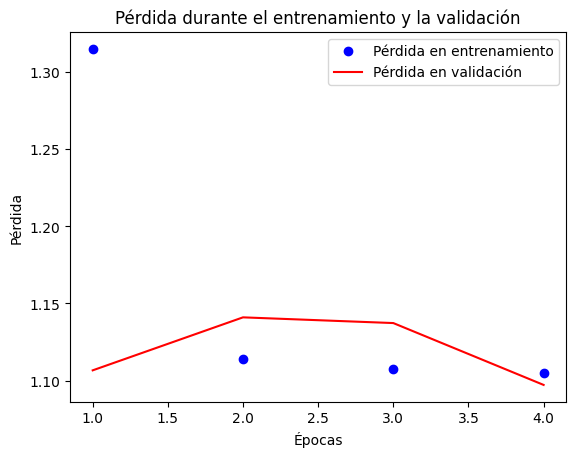

In [0]:
import matplotlib.pyplot as plt
# Crear gráfico de pérdida durante el entrenamiento
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'bo', label='Pérdida en entrenamiento')
plt.plot(epochs, val_loss, 'r', label='Pérdida en validación')
plt.title('Pérdida durante el entrenamiento y la validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [0]:
np.unique(y_pred_rnn)

array([-1,  4,  5,  6])

In [0]:
# Registrar un modelo en MLflow
model_path = "dbfs:/databricks/mlflow-tracking/8323b80e926241ee8763b7dc43085602/3fdcef4bd83943ec9dc2188bc13045f4/artifacts/model"
model_name = "MLops_kerastf_v1"
mlflow.register_model(model_path, model_name)

Successfully registered model 'MLops_kerastf_v1'.
2024/03/20 15:58:44 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: MLops_kerastf_v1, version 1
Created version '1' of model 'MLops_kerastf_v1'.


<ModelVersion: aliases=[], creation_timestamp=1710950324752, current_stage='None', description='', last_updated_timestamp=1710950324752, name='MLops_kerastf_v1', run_id='', run_link='', source='dbfs:/databricks/mlflow-tracking/8323b80e926241ee8763b7dc43085602/3fdcef4bd83943ec9dc2188bc13045f4/artifacts/model', status='PENDING_REGISTRATION', status_message='', tags={}, user_id='4044096405736964', version='1'>

In [0]:
#ver el directorio local de databrinks mas no el local de .os
dbutils.fs.ls("dbfs:/")

[FileInfo(path='dbfs:/FileStore/', name='FileStore/', size=0, modificationTime=1707261293000),
 FileInfo(path='dbfs:/Volume/', name='Volume/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/Volumes/', name='Volumes/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/databricks-datasets/', name='databricks-datasets/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/databricks-results/', name='databricks-results/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/directorio_de_prueba/', name='directorio_de_prueba/', size=0, modificationTime=1710260952000),
 FileInfo(path='dbfs:/mnt/', name='mnt/', size=0, modificationTime=1707334085000),
 FileInfo(path='dbfs:/modelosml/', name='modelosml/', size=0, modificationTime=1710252635000),
 FileInfo(path='dbfs:/nuevomodelo/', name='nuevomodelo/', size=0, modificationTime=1710267910000),
 FileInfo(path='dbfs:/tmp/', name='tmp/', size=0, modificationTime=1710255472000),
 FileInfo(path='dbfs:/volume/', name='volume/', size=0, modification

### Guardar Modelo en Azure Storage

In [0]:
#1. Guardar en el directorio LOCAL (.OS)
model_rnn.save('/nuevomodelo/modelrnn_nuevo')

INFO:tensorflow:Assets written to: /nuevomodelo/modelrnn_nuevo/assets


INFO:tensorflow:Assets written to: /nuevomodelo/modelrnn_nuevo/assets


In [0]:
#2. Verificar que se ha guardado en el directorio LOCAL (.OS)
import os
os.listdir("/modelornn_version1_d4m")

['modelornn_version1']

Opcion 1: Cargar el Modelo ML directamente del Directorio (.OS)

In [0]:
# Cargar el modelo desde el contenedor de almacenamiento Azure
loaded_model_nuevo = tf.keras.models.load_model("/nuevomodelo/modelrnn_nuevo")

Opcion  2: Copiar el Modelo ML desde el Directorio LOCAL(.OS)  HASTA  Directorio de DBFS de Azure DataBrinks

In [0]:
#copie los datos desde LOCAL(.OS) a DBFS como dbfs (DIRECTORIO DE DATABRINKS)
dbutils.fs.cp("file:/nuevomodelo/modelrnn_nuevo", "dbfs:/nuevomodelo/modelrnn_nuevo", recurse=True) # True: si copias una carpeta, False: si #solo es archivo

True

Verificar que se ha migrado desde Directorio LOCAL(.OS)  Hacia Directorio DBFS

In [0]:
display(dbutils.fs.ls("/nuevomodelo/modelrnn_nuevo"))

path,name,size,modificationTime
dbfs:/nuevomodelo/modelrnn_nuevo/assets/,assets/,0,1710267911000
dbfs:/nuevomodelo/modelrnn_nuevo/fingerprint.pb,fingerprint.pb,58,1710267911000
dbfs:/nuevomodelo/modelrnn_nuevo/keras_metadata.pb,keras_metadata.pb,8373,1710267911000
dbfs:/nuevomodelo/modelrnn_nuevo/saved_model.pb,saved_model.pb,87561,1710267911000
dbfs:/nuevomodelo/modelrnn_nuevo/variables/,variables/,0,1710267910000


Copiar el modelo desde el directorio DBFS al contenedor de almacenamiento Azure Storage

In [0]:
# Copiar el modelo desde el directorio DBFS al contenedor de almacenamiento Azure Storage
dbutils.fs.cp("/nuevomodelo/modelrnn_nuevo", "/mnt/datalakemlopsd4m/presentation/modelrnn_nuevo", recurse=True) #True:Copycarpeta,#False:Copyarchivo

True

  3302/117796 [..............................] - ETA: 4:58 - loss: 1.3806

*** WARNING: max output size exceeded, skipping output. ***

117776/117796 [============================>.] - ETA: 0s - loss: 1.1365

/local_disk0/.ephemeral_nfs/cluster_libraries/python/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 236ms/step
INFO:tensorflow:Assets written to: /local_disk0/repl_tmp_data/ReplId-14699-38d2c-a7ee2-8/tmpy60a2jlm/model/data/model/assets


INFO:tensorflow:Assets written to: /local_disk0/repl_tmp_data/ReplId-14699-38d2c-a7ee2-8/tmpy60a2jlm/model/data/model/assets
2024/03/21 21:31:30 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/databricks/python/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


Uploading artifacts:   0%|          | 0/12 [00:00<?, ?it/s]

2024/03/21 21:31:30 INFO mlflow.store.artifact.cloud_artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false


Uploading artifacts:   0%|          | 0/2 [00:00<?, ?it/s]

2024/03/21 21:31:32 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /local_disk0/repl_tmp_data/ReplId-14699-38d2c-a7ee2-8/tmpxf723mr_/model/data/model/assets


INFO:tensorflow:Assets written to: /local_disk0/repl_tmp_data/ReplId-14699-38d2c-a7ee2-8/tmpxf723mr_/model/data/model/assets
2024/03/21 21:31:40 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.11.1/models.html#set-signature-on-logged-model for instructions on setting a model signature on your logged model.


Uploading artifacts:   0%|          | 0/12 [00:00<?, ?it/s]

2024/03/21 21:31:40 INFO mlflow.store.artifact.cloud_artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false
Successfully registered model 'MLops_kerastf_3_21_24'.
2024/03/21 21:31:42 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: MLops_kerastf_3_21_24, version 1
Created version '1' of model 'MLops_kerastf_3_21_24'.


<ModelVersion: aliases=[], creation_timestamp=1711056702253, current_stage='None', description='', last_updated_timestamp=1711056702253, name='MLops_kerastf_3_21_24', run_id='', run_link='', source='dbfs:/databricks/mlflow-tracking/8323b80e926241ee8763b7dc43085602/1e33f39bbed348c9bebf9a1e098b28ad/artifacts/keras_tf_3_21_24', status='PENDING_REGISTRATION', status_message='', tags={}, user_id='4044096405736964', version='1'>

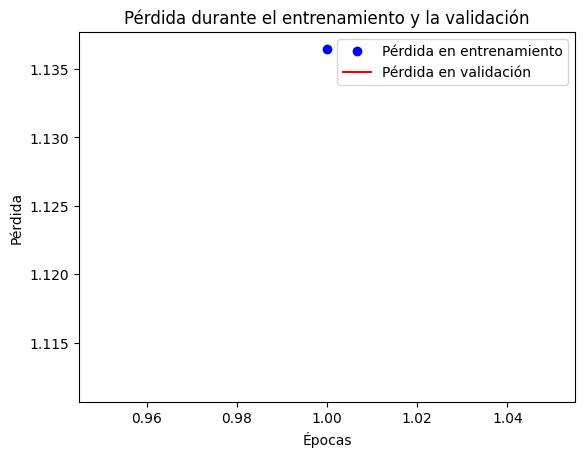

In [0]:
import pandas as pd
import mlflow
import mlflow.keras
import mlflow.tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# # Establecer la URI de seguimiento de MLflow
# mlflow.set_tracking_uri("databricks")  # Usa "databricks" para Databricks

# # Crear un nuevo experimento si no existe
# experiment_name = "nombre_del_experimento"
# mlflow.set_experiment(experiment_name)

# Cargar los datos
df_delta = spark.read.format("delta").load("/mnt/datalakemlopsd4m/presentation/datmarcobre_fengineer_tablacaract_delta")
datos = df_delta.toPandas()

# Separar las variables independientes y dependiente
X = datos[['capacidad_en_volumen_equipo_carguio_m3',
           'capacidad_en_peso_equipo_carguio',
           'capacidad_en_peso_equipo_acarreo',
           'densidad_inicial_poligono_creado_tn/m3',
           'capacidad_en_volumen_equipo_acarreo_m3']].values
y = datos['numero_pases_carguio'].values

# Construir el modelo de red neuronal
np.random.seed(42)
tf.random.set_seed(42)

X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(X, y, test_size=0.2, random_state=42)

mlflow.tensorflow.autolog()  # Keras y TensorFlow

# Entrenar el modelo
with mlflow.start_run(run_name='experimento_mlflow_keras_tf_3_21_24'):  #Iniciliza un nuevo experimento de MlFlow
    model_rnn = Sequential()
    model_rnn.add(LSTM(30, activation='relu', input_shape=(1, 5)))
    model_rnn.add(Dense(60, activation='relu'))
    model_rnn.add(Dense(30, activation='relu'))
    model_rnn.add(Dense(15, activation='relu'))
    model_rnn.add(Dense(1, activation='linear'))

    model_rnn.compile(loss='mean_squared_error', optimizer='adam')

    history = model_rnn.fit(X_train_rnn.reshape(-1, 1, 5), y_train_rnn, epochs=1, 
                            validation_data=(X_test_rnn.reshape(-1, 1, 5), y_test_rnn), 
                            batch_size=5, verbose=1)

    # Registrar los parámetros del modelo
    mlflow.log_params({
        "input_shape": (1, 5),
        "lstm_units": 30,
        "dense_layers": [60, 30, 15],
        "activation": "relu",
        "optimizer": "adam",
        "loss_function": "mean_squared_error",
        "epochs": 1,
        "batch_size": 5
    })

    # Registrar la estructura del modelo en MLflow
    mlflow.keras.log_model(model_rnn, "keras_tf_3_21_24")

    # Calcular métricas
    train_loss = history.history['loss']
    test_loss = history.history['val_loss']
    train_rmse = np.sqrt(train_loss)
    test_rmse = np.sqrt(test_loss)

    # Registrar métricas de RMSE
    mlflow.log_metric("train_RMSE", train_rmse[-1])
    mlflow.log_metric("test_RMSE", test_rmse[-1])

    # Crear gráfico de pérdida durante el entrenamiento
    epochs = range(1, len(train_loss) + 1)
    plt.plot(epochs, train_loss, 'bo', label='Pérdida en entrenamiento')
    plt.plot(epochs, test_loss, 'r', label='Pérdida en validación')
    plt.title('Pérdida durante el entrenamiento y la validación')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.savefig("kerasplot_3_21_24.png")
    mlflow.log_artifact("kerasplot_3_21_24.png")

    # Obtener la ruta del modelo registrado
    model_path = mlflow.get_artifact_uri("keras_tf_3_21_24")

# Registrar el modelo en MLflow
model_name = "MLops_kerastf_3_21_24"
mlflow.register_model(model_path, model_name)